# Energy Resolution of Germanium detectors

Eugenia Boccanera 2109310  
Lucrezia Rossi 2122164

NaI and Germanium detectors have wide fields of application for γ- and X-ray spectrometry thanks to their good energy resolution. The energy resolution of these detectors is defined as the width of the detected energy spectra peaks (FWHM); it depends on  
    - the statistics of the charge creation process  
    - the properties of the detector, and primarly its charge collelction efficency   
    - the electronics noise  

The resolution can be expressed as the squared sum of two terms:   
$$FWHM = \sqrt{(w_d)^2 + (w_e)^2}$$   
where the first term depends on the detector properties as:  
$w_d = 2 * \sqrt{(2 * \log(2)) * F * E_{\gamma} * w}$   
with $F$ the _Fano factor_,  
$E_{\gamma}$  the energy of the photon deposited energy  
$w$ the electron hole-produced energy threshold in germanium (w ~ 3eV).

The $w_e$ term in eq.1 is connected with the readout electronics and depends on the detector capacitance, the size of the detector and the bias voltage.


## Step 1. Data Inspection and FWHM derivation

In [192]:
# Functions
# Function to plot the spectrum
plot_spectrum <- function(data, title) {
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line(col='black', lwd=0.2, na.rm = TRUE) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("log(Counts)") +
    theme_minimal() +
    theme(axis.title = element_text(size = 14))
}

# Function to find indices of values closest to specified x values
find_indices_around_x <- function(data, x_values) {
  indices <- numeric(0)
  for (x_val in x_values) {
    index <- which.min(abs(data$Channel - x_val))
    indices <- c(indices, index)
  }
  return(indices)
}

# Function to smooth data
smooth_data <- function(data, window_size) {
  smoothed_values <- movavg(data$log_Count, n = window_size, type = "s")
  smoothed_data <- data
  smoothed_data$log_Count <- smoothed_values
  return(smoothed_data)
}

#  Function to plot the peaks 
plot_peaks_around_x <- function(data, title, x_values, window_size, apply_smoothing = TRUE) {
  if (apply_smoothing) {
    data <- smooth_data(data, window_size)
  }
  indices <- find_indices_around_x(data, x_values)
  
  # Plot the data with red points at specified x values
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line() +
    geom_point(data = data[indices, ], aes(x = Channel, y = log_Count), color = "red", size = 2) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("Log(Counts)") +
    theme_minimal() +
    theme(plot.title = element_text(size = 20),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12))
}

# Function to finth the position of the peaks
find_and_return_peaks_around_x <- function(data, x_values, window_size, apply_smoothing = TRUE) {
  if (apply_smoothing) {
    data <- smooth_data(data, window_size)
  }
  indices <- find_indices_around_x(data, x_values)
  # Get peak position
  peak_positions <- data$Channel[indices]
  # Return peak positions
  return(peak_positions)
}

# Function to extract data points around each peak
extract_peak_data <- function(data, peak_positions, window_size) {
  peak_data_list <- list()
  for (peak_pos in peak_positions) {
    # Find the closest index to the peak position
    index <- which.min(abs(data$Channel - peak_pos))
    
    # Extract data within the window size around the peak position
    start_index <- max(1, index - window_size)
    end_index <- min(nrow(data), index + window_size)
    
    # Subset the data
    peak_data <- data[start_index:end_index, ]
    # Store the subsetted data in a list with peak position as key
    peak_data_list[[as.character(peak_pos)]] <- peak_data
  }
  
  return(peak_data_list)
}

# Function to fit Gaussian model using nls
fit_gaussian_nls <- function(peak_data) {
  # Initial guesses for the parameters
  mu_init <- peak_data$Channel[which.max(peak_data$log_Count)]
  sigma_init <- diff(range(peak_data$Channel)) / 4  # Quarter of the range
  A_init <- max(peak_data$log_Count)
  
  # Define the Gaussian function
  gaussian <- function(x, mu, sigma, A) {
    A * exp(-0.5 * ((x - mu) / sigma)^2)
  }
  
  # Fit the model using nls
  fit <- nls(log_Count ~ gaussian(Channel, mu, sigma, A), data = peak_data,
             start = list(mu = mu_init, sigma = sigma_init, A = A_init),
             control = nls.control(maxiter = 100))
  return(fit)
}

# Function to calculate FWHM from fitted Gaussian parameters
calculate_fwhm <- function(fit) {
  coef_fit <- coef(fit)  # extract the coefficients
  sigma <- coef_fit["sigma"]
  FWHM <- 2 * sqrt(2 * log(2)) * sigma
  return(FWHM)
}

### 1.a Load the required libraries

In [193]:
# Load the libraries
library(rjags)
library(ggplot2)
library(bayesplot)

library(dplyr)
library(nlstools)
library(pracma)

library(gridExtra)


### 1.b Load the data

The data in the files represent a typical energy spectrum obtained from a detector, in this case, a germanium detector, after being irradiated by a source containing a specific element. Each row of the file contains two values:

The first value represents the detector channel, which is essentially the index or position of the data in the file.
The second value represents the number of counts (or events) recorded in that channel during the energy measurement.

**Detector Channel:**

Every energy detector (such as a germanium detector) divides the range of energy it can measure into discrete channels. Each channel corresponds to a specific energy range that the detector can detect.

**Counts:**

The recorded counts represent the number of times the detector has detected an energy event (a gamma photon, in the case of a germanium detector) in that particular channel during the experimen



In [194]:
# Load the data
gr11_co60 <- read.table("gr11_co60.txt", header = FALSE)
gr11_cs137 <- read.table("gr11_cs137.txt", header = FALSE)
gr11_na22 <- read.table("gr11_na22.txt", header = FALSE)
IC48A_AmCsCo <- read.table("IC48A_AmCsCo.txt", header = FALSE)
IC48A_Th <- read.table("IC48A_Th.txt", header = FALSE)

# Assign column names
colnames(gr11_co60) <- c("Channel", "Count")
colnames(gr11_cs137) <- c("Channel", "Count")
colnames(gr11_na22) <- c("Channel", "Count")
colnames(IC48A_AmCsCo) <- c("Channel", "Count")
colnames(IC48A_Th) <- c("Channel", "Count")

# Drop the rows with Count < 0
gr11_co60 <- gr11_co60[gr11_co60$Count >= 0, ]
gr11_cs137 <- gr11_cs137[gr11_cs137$Count >= 0, ]
gr11_na22 <- gr11_na22[gr11_na22$Count >= 0, ]
IC48A_AmCsCo <- IC48A_AmCsCo[IC48A_AmCsCo$Count >= 0, ]
IC48A_Th <- IC48A_Th[IC48A_Th$Count >= 0, ]

# Add the column log_Count
gr11_co60$log_Count <- log(gr11_co60$Count + 1)
gr11_cs137$log_Count <- log(gr11_cs137$Count + 1)
gr11_na22$log_Count <- log(gr11_na22$Count + 1)
IC48A_AmCsCo$log_Count <- log(IC48A_AmCsCo$Count + 1)
IC48A_Th$log_Count <- log(IC48A_Th$Count + 1)




### 1.c Inspect the Data - Plot the Spectra

Each peak in the spectrum represents a specific energy of the gamma photons emitted by radioactive sources such as Co-60, Cs-137, Na-22, AmCsCo, or Th. Analyzing these spectra allows for the identification and characterization of the radioactive sources present, evaluation of the detector's energy resolution, and the study of other properties of the detector and the sources.

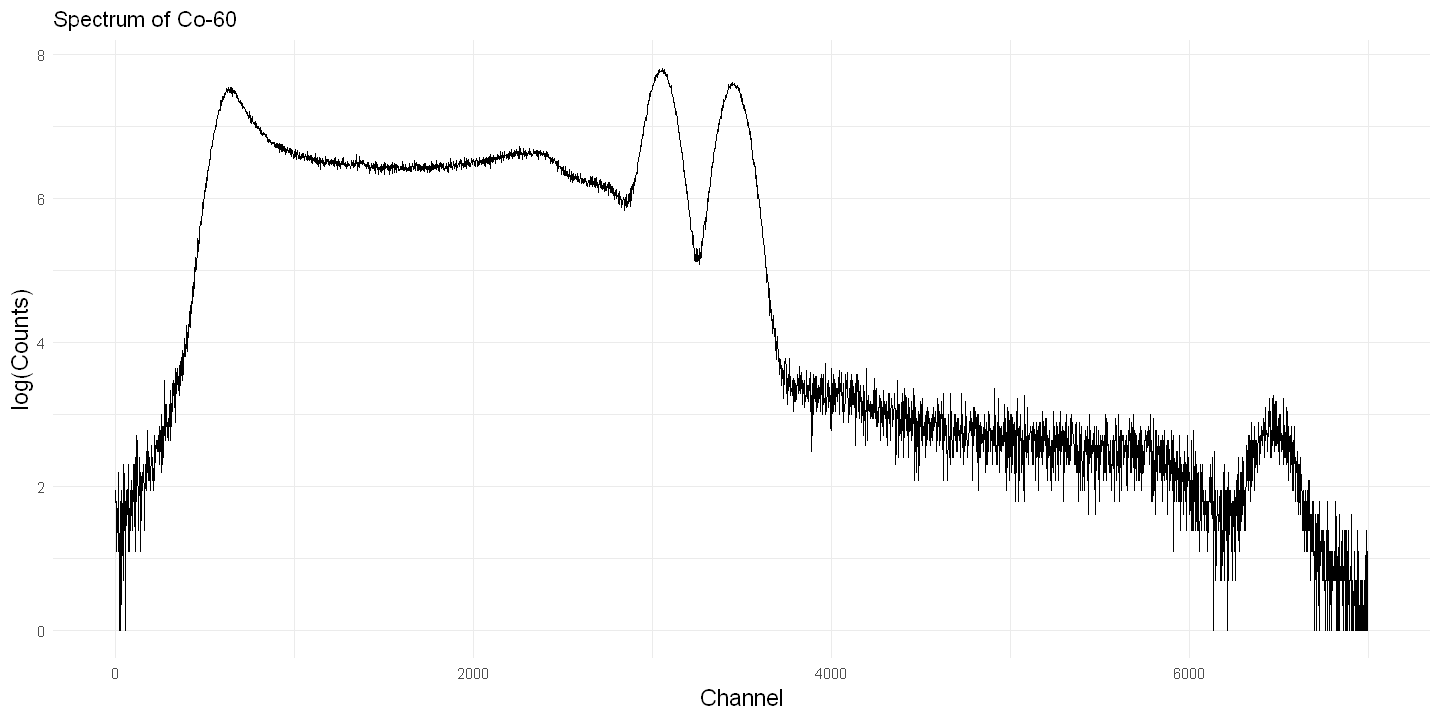

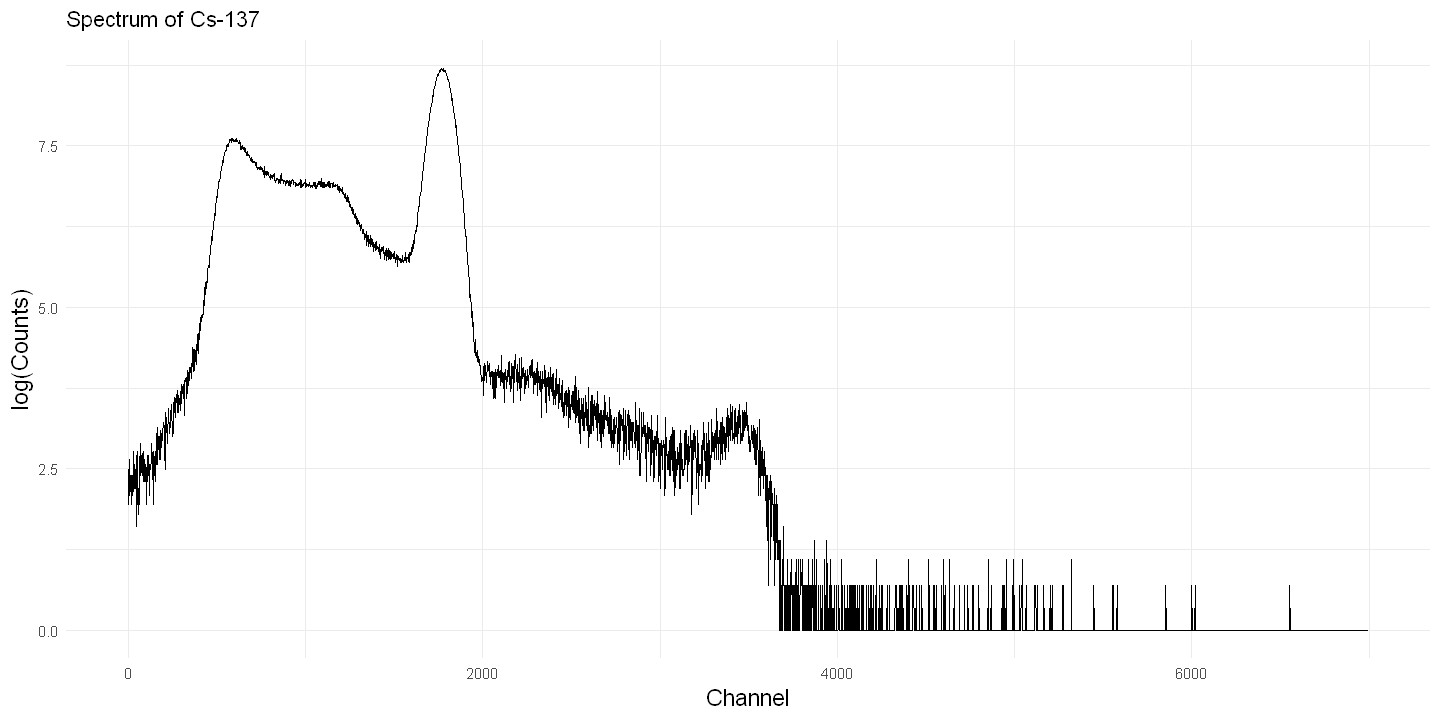

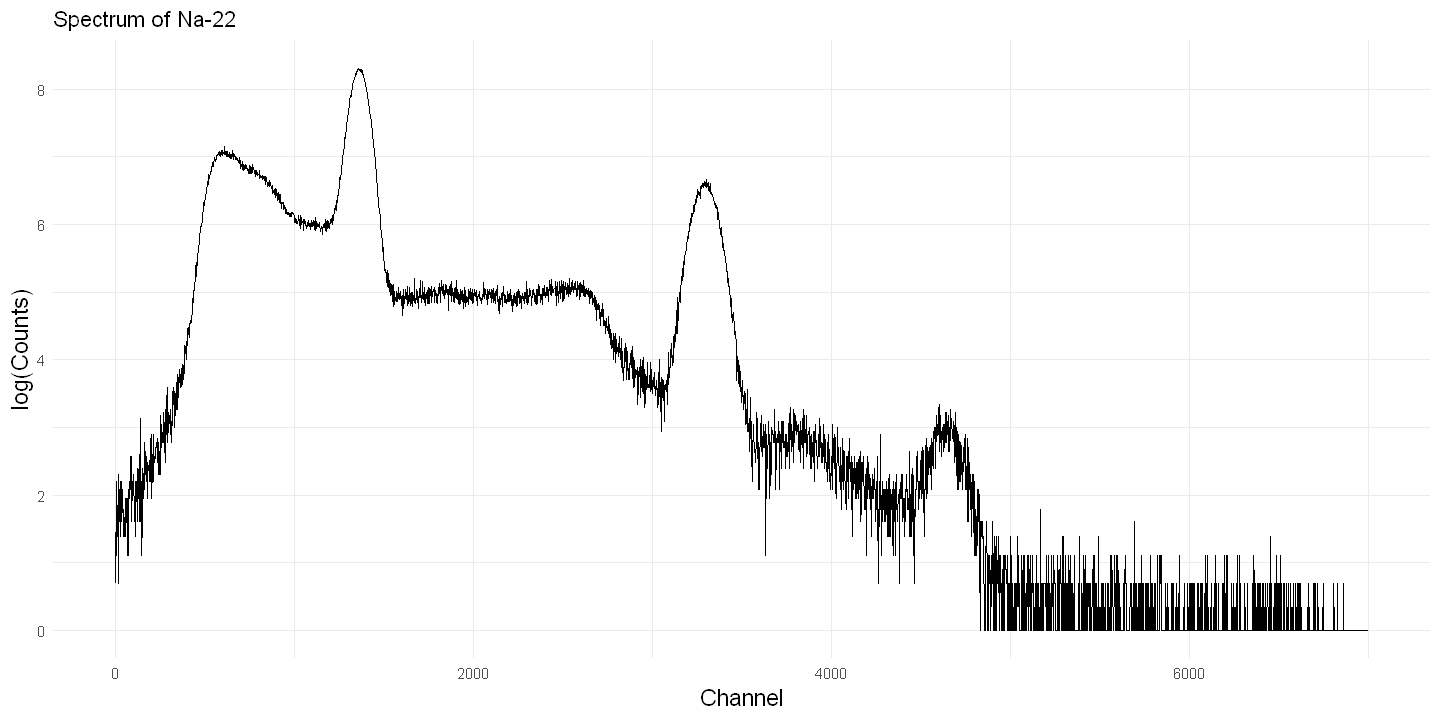

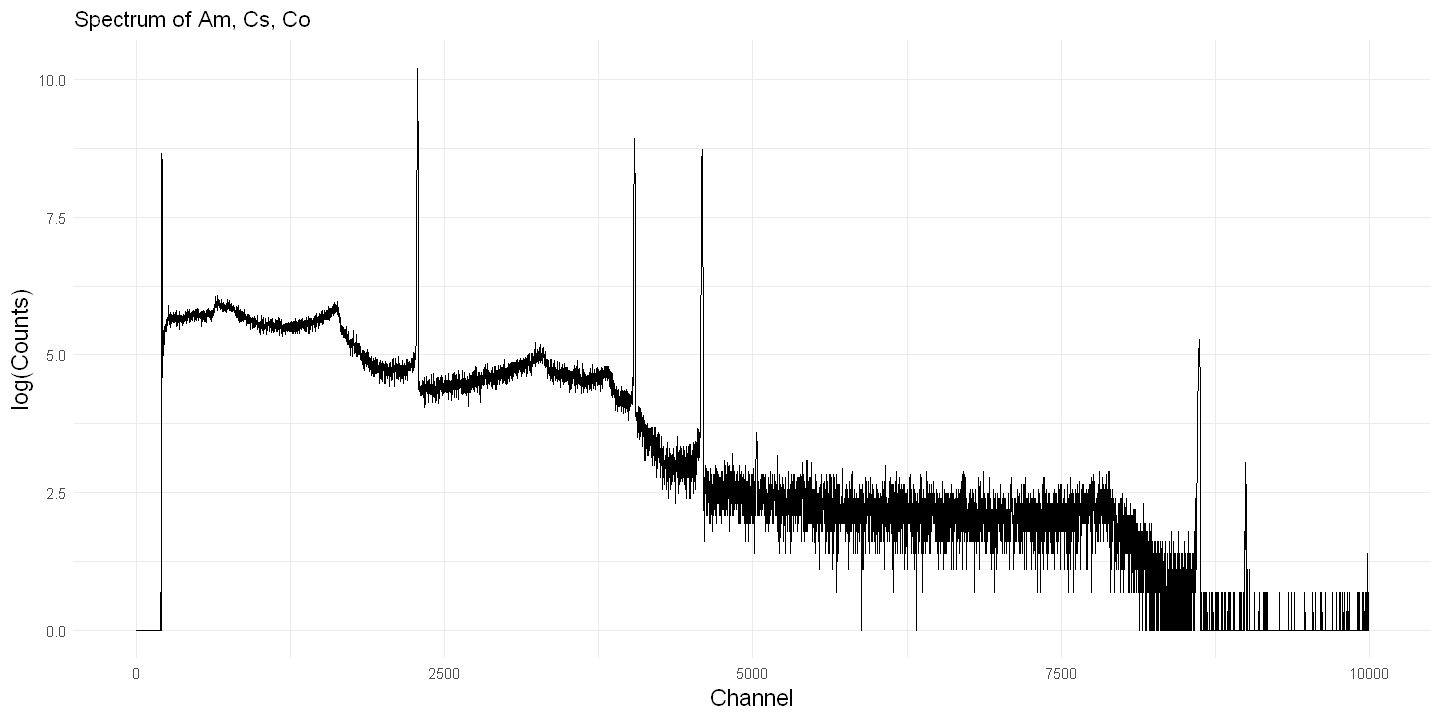

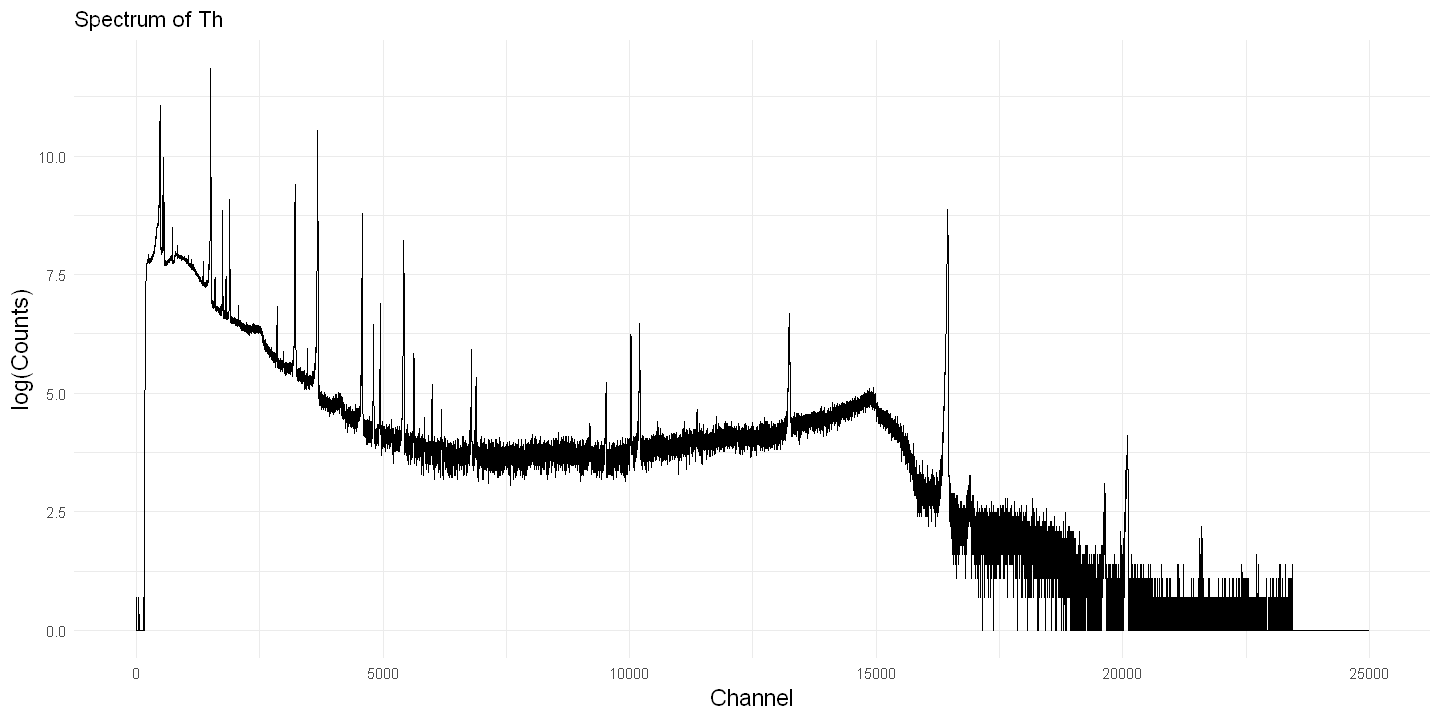

In [195]:
# Plot function
options(repr.plot.width = 12, repr.plot.height = 6)

# Plot each spectrum
plot_spectrum(gr11_co60, "Spectrum of Co-60")
plot_spectrum(gr11_cs137, "Spectrum of Cs-137")
plot_spectrum(gr11_na22, "Spectrum of Na-22")
plot_spectrum(IC48A_AmCsCo, "Spectrum of Am, Cs, Co")
plot_spectrum(IC48A_Th, "Spectrum of Th")


### 1.d Find Peaks  and Infer FWHM

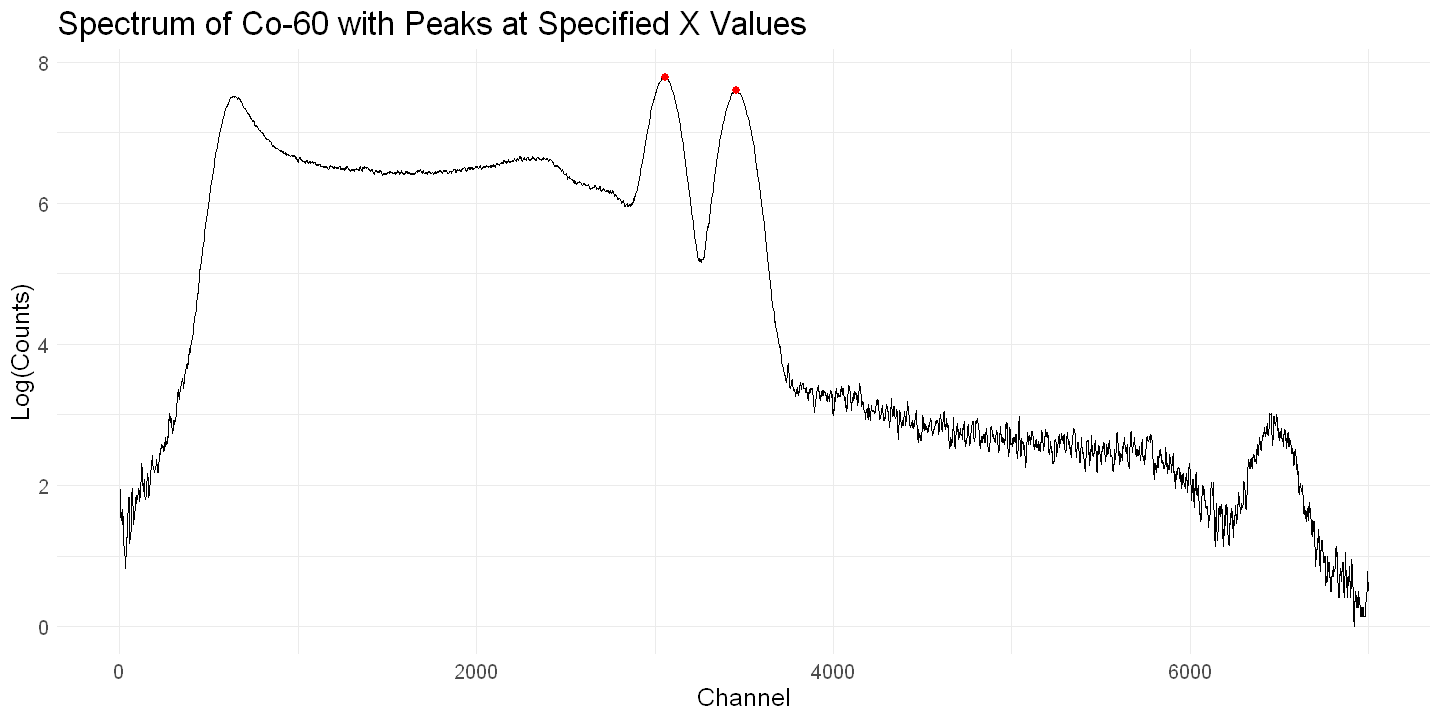

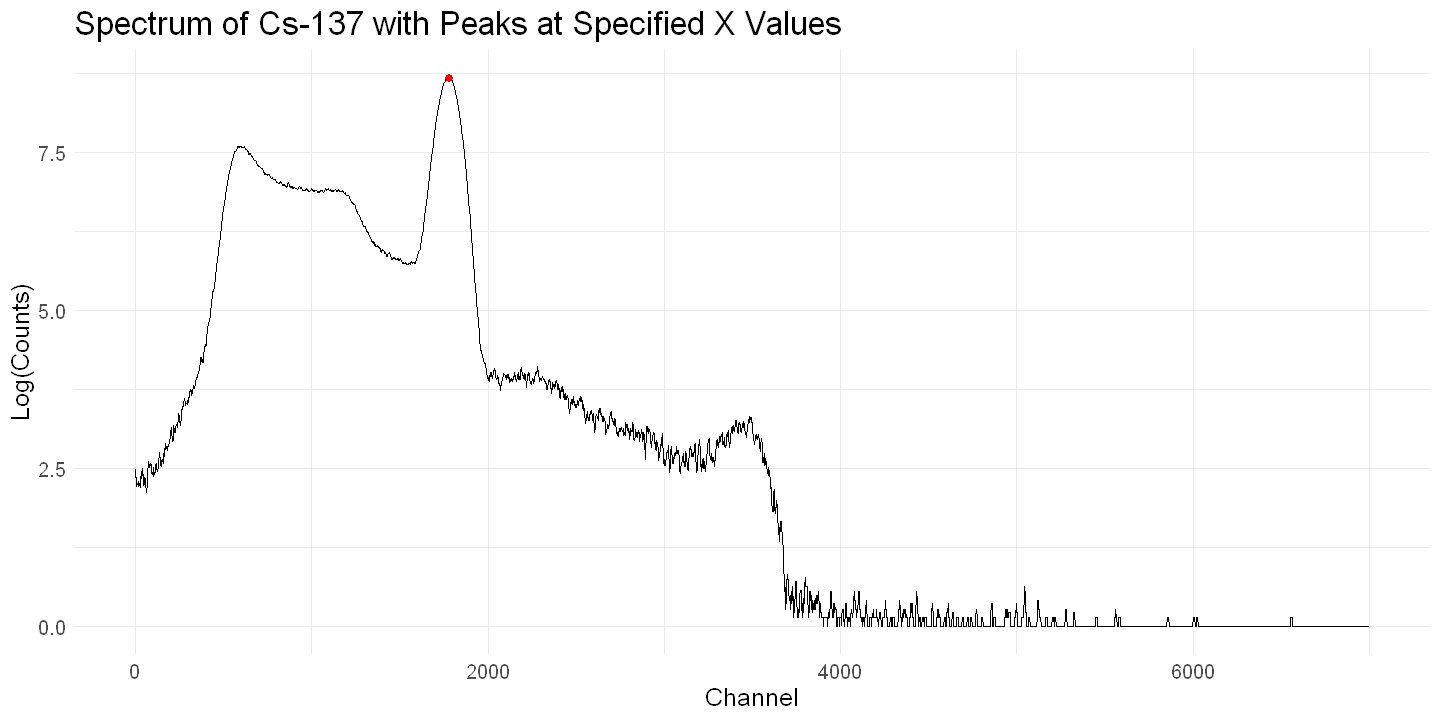

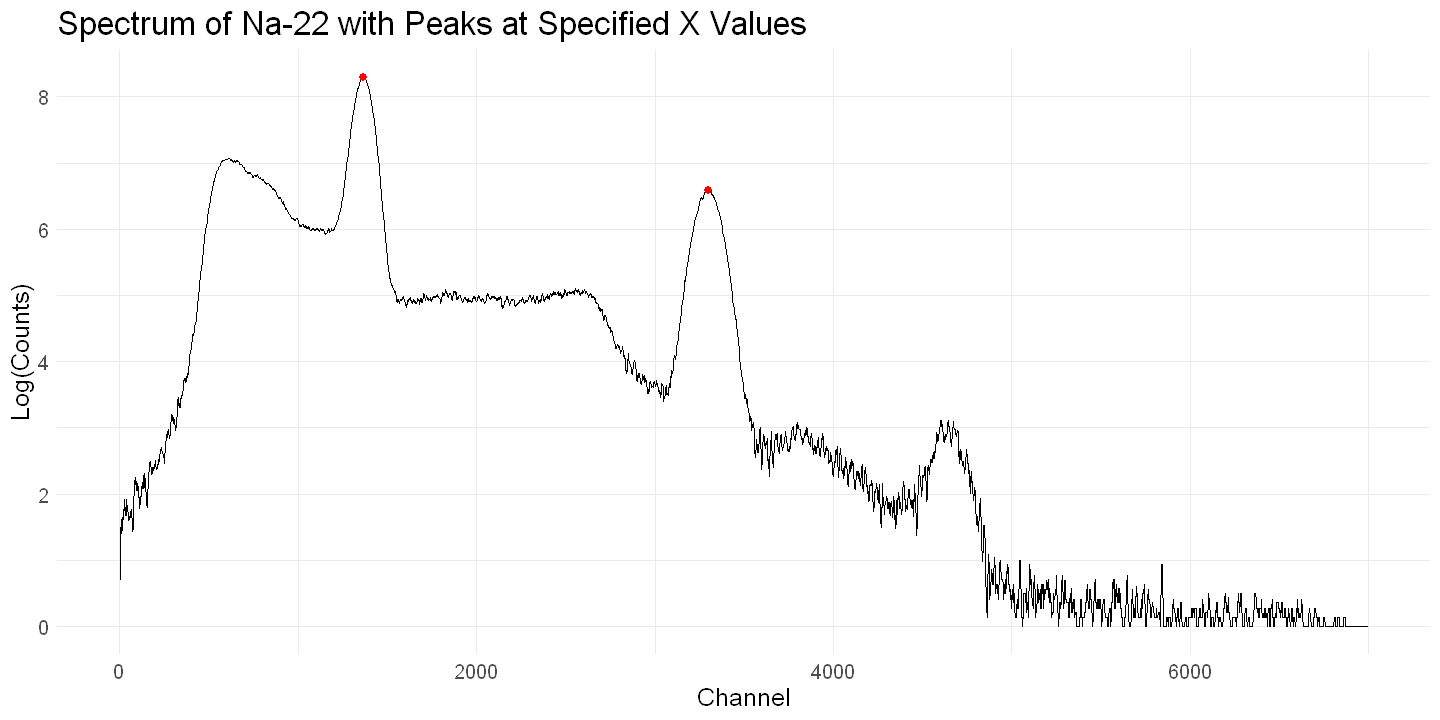

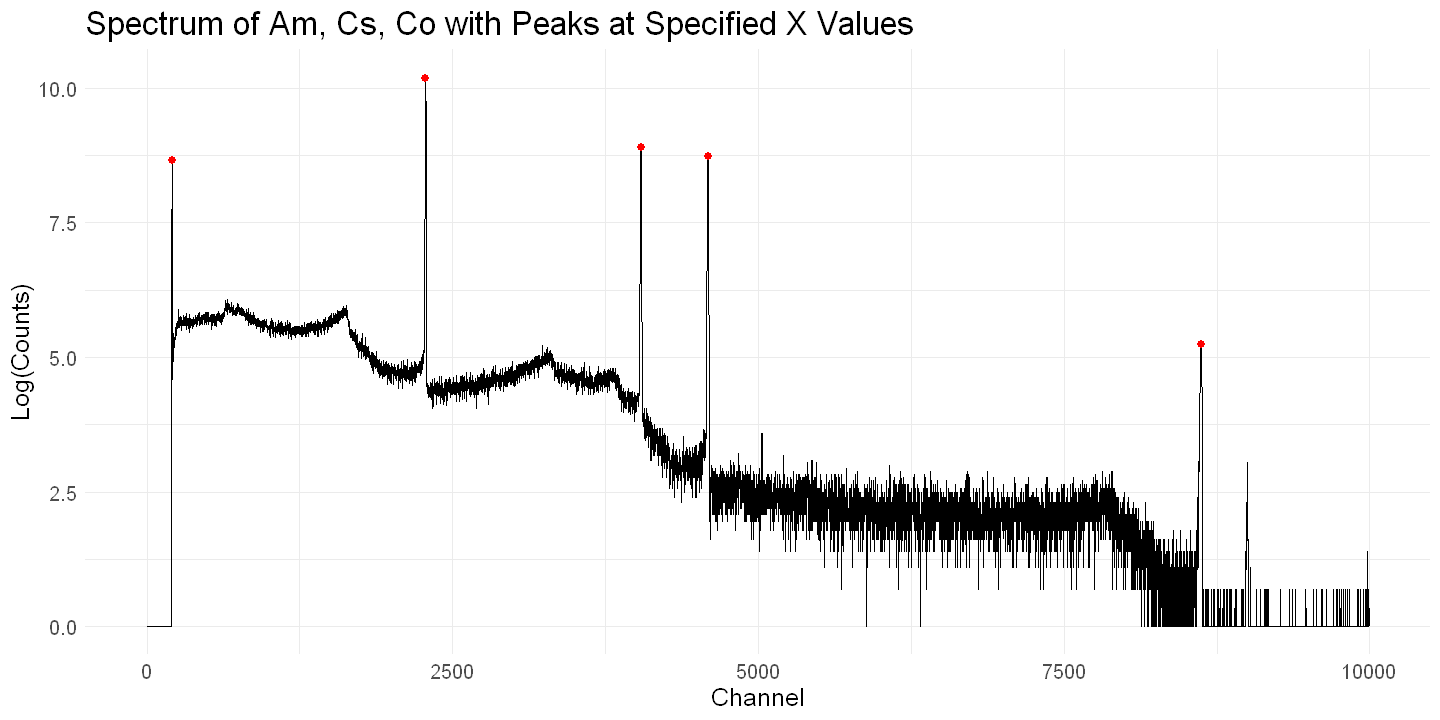

[1] 3057 3457

[1] 1779

[1] 1365 3301

[1]  206 2280 4041 4589 8623

[1]   485  1504  1890  3218  3674  4581  4948  5420  6793  9525 10025 10202
[13] 13240 16452 20099

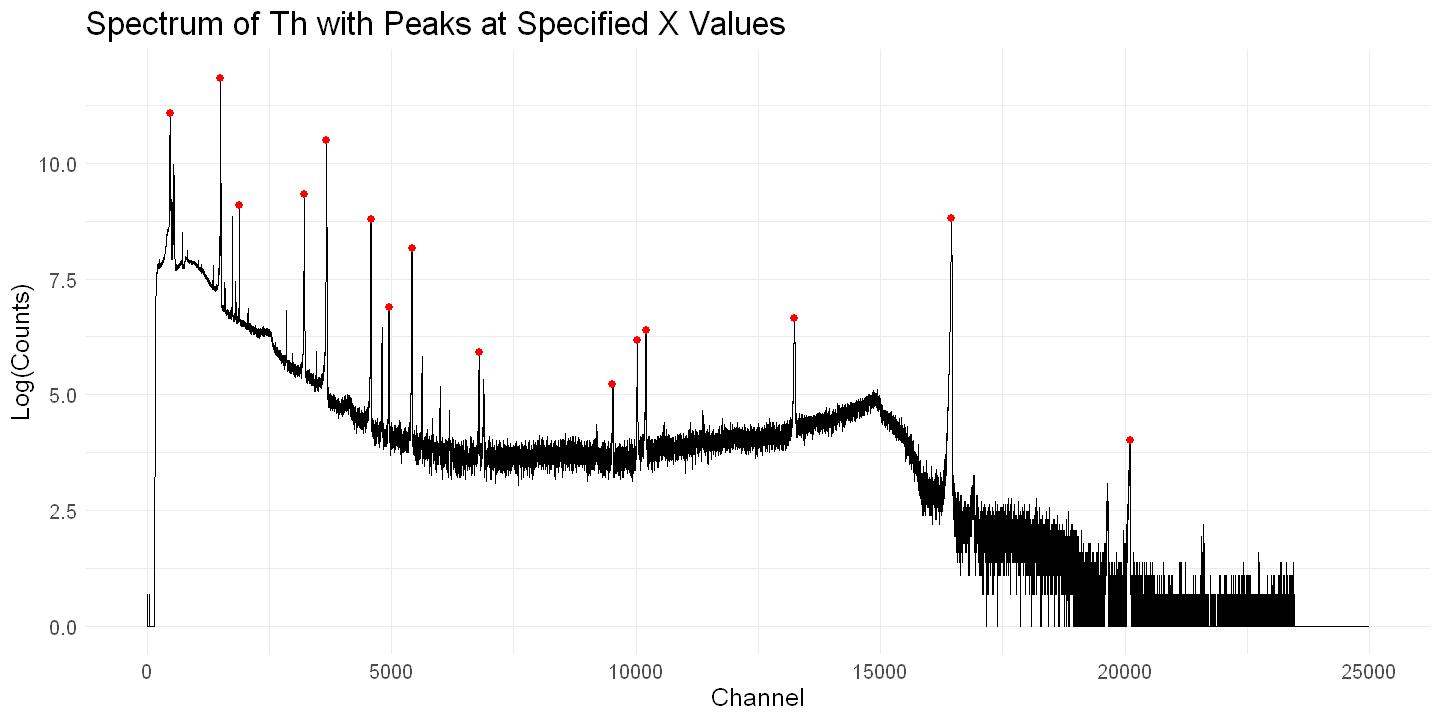

In [196]:
# Inferred initial positions of the peaks
position_co60 <- c(3058, 3458)
position_cs137 <- c(1779)
position_na22 <- c(1366, 3302)
position_AmCsCo<- c(206, 2280, 4041, 4589, 8623) 
position_Th <- c( 485, 1504,1890,  3218, 3674, 4581,4948 , 5420, 6793, 9525, 10025, 10202,13240, 16452, 20099) 

# Plot the peak positions
plot_peaks_around_x(gr11_co60, "Spectrum of Co-60 with Peaks at Specified X Values", x_values =position_co60, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(gr11_cs137, "Spectrum of Cs-137 with Peaks at Specified X Values", x_values = position_cs137, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(gr11_na22, "Spectrum of Na-22 with Peaks at Specified X Values", x_values = position_na22, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(IC48A_AmCsCo, "Spectrum of Am, Cs, Co with Peaks at Specified X Values", x_values = position_AmCsCo, window_size = 8, apply_smoothing = FALSE)
plot_peaks_around_x(IC48A_Th, "Spectrum of Th with Peaks at Specified X Values", x_values = position_Th, window_size = 8, apply_smoothing = FALSE)

# Return the peak positions
peaks_co60 <- find_and_return_peaks_around_x (gr11_co60, x_values = position_co60, window_size = 5, apply_smoothing = TRUE)
peaks_cs137 <- find_and_return_peaks_around_x (gr11_cs137, x_values = position_cs137, window_size = 5, apply_smoothing = TRUE)
peaks_na22 <- find_and_return_peaks_around_x (gr11_na22, x_values = position_na22, window_size = 5, apply_smoothing = TRUE)
peaks_AmCsCo <- find_and_return_peaks_around_x (IC48A_AmCsCo, x_values = position_AmCsCo, window_size = 8, apply_smoothing = FALSE)
peaks_Th <- find_and_return_peaks_around_x (IC48A_Th, x_values = position_Th, window_size = 8, apply_smoothing = FALSE)

peaks_co60
peaks_cs137
peaks_na22
peaks_AmCsCo
peaks_Th

In [197]:
# Extract data points around each peak
peak_data_list_AmCsCo <- extract_peak_data(IC48A_AmCsCo, peaks_AmCsCo, window_size = 13)
peak_data_list_Th <- extract_peak_data(IC48A_Th, peaks_Th, window_size = 9)
print(peak_data_list_AmCsCo) # example


$`206`
    Channel Count log_Count
194     193     0 0.0000000
195     194     0 0.0000000
196     195     0 0.0000000
197     196     0 0.0000000
198     197     0 0.0000000
199     198     1 0.6931472
200     199     0 0.0000000
201     200     1 0.6931472
202     201     3 1.3862944
203     202    48 3.8918203
204     203   328 5.7960578
205     204  1459 7.2861917
206     205  3690 8.2136527
207     206  5758 8.6585191
208     207  4707 8.4570185
209     208  2114 7.6568101
210     209   570 6.3473892
211     210   193 5.2678582
212     211    97 4.5849675
213     212   132 4.8903491
214     213   136 4.9199809
215     214   150 5.0172798
216     215   146 4.9904326
217     216   161 5.0875963
218     217   169 5.1357984
219     218   231 5.4467374
220     219   230 5.4424177

$`2280`
     Channel Count log_Count
2268    2267   182  5.209486
2269    2268   188  5.241747
2270    2269   195  5.278115
2271    2270   225  5.420535
2272    2271   324  5.783825
2273    2272   536  6.2859

### 1.e Fit Gaussian and Calculate FWHM 

Now we fit a Gaussian model to peak data using initial parameter guesses and non-linear least squares optimization. Then we apply this fitting procedure to the sets of peak data and outputs the results.

In [198]:
# Fit the model for each peak
fits_AmCsCo <- lapply(peak_data_list_AmCsCo, fit_gaussian_nls)
fits_Th <- lapply(peak_data_list_Th, fit_gaussian_nls)

cat('Fits_AmCsCo: \n')
fits_AmCsCo
cat('Fits_Th: \n')
fits_Th


Fits_AmCsCo: 


$`206`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
     mu   sigma       A 
209.717   6.894   7.135 
 residual sum-of-squares: 67.93

Number of iterations to convergence: 14 
Achieved convergence tolerance: 6.629e-06

$`2280`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
      mu    sigma        A 
2278.831    8.966    9.605 
 residual sum-of-squares: 15

Number of iterations to convergence: 7 
Achieved convergence tolerance: 2.273e-06

$`4041`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
      mu    sigma        A 
4039.188    9.727    8.816 
 residual sum-of-squares: 4.237

Number of iterations to convergence: 5 
Achieved convergence tolerance: 9.817e-06

$`4589`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
      mu    sigma        A 
4586.778    9.175    8.898 
 residual

Fits_Th: 


$`485`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
    mu  sigma      A 
484.15  11.87  10.61 
 residual sum-of-squares: 2.973

Number of iterations to convergence: 6 
Achieved convergence tolerance: 8.235e-06

$`1504`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
     mu   sigma       A 
1503.04   10.21   11.63 
 residual sum-of-squares: 1.918

Number of iterations to convergence: 6 
Achieved convergence tolerance: 1.206e-06

$`1890`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
      mu    sigma        A 
1889.879   11.177    8.873 
 residual sum-of-squares: 0.9691

Number of iterations to convergence: 6 
Achieved convergence tolerance: 2.39e-06

$`3218`
Nonlinear regression model
  model: log_Count ~ gaussian(Channel, mu, sigma, A)
   data: peak_data
     mu   sigma       A 
3216.44   12.16    9.31 
 residual sum-of-squares:

In [199]:
# Calculate FWHM for each peak
fwhm_values_AmCsCo <- sapply(fits_AmCsCo, calculate_fwhm)
cat('FWHM values for AmCsCo: \n')
print(fwhm_values_AmCsCo)

fwhm_values_Th <- sapply(fits_Th, calculate_fwhm)
cat('FWHM values for Th: \n')
print(fwhm_values_Th)


FWHM values for AmCsCo: 
 206.sigma 2280.sigma 4041.sigma 4589.sigma 8623.sigma 
  16.23476   21.11418   22.90557   21.60508   23.87002 
FWHM values for Th: 
  485.sigma  1504.sigma  1890.sigma  3218.sigma  3674.sigma  4581.sigma 
   27.95363    24.04903    26.31983    28.63988    25.74755    26.49359 
 4948.sigma  5420.sigma  6793.sigma  9525.sigma 10025.sigma 10202.sigma 
   25.94296    27.12377    29.26375    34.16497    32.63046    36.35886 
13240.sigma 16452.sigma 20099.sigma 
   53.89640    49.46723    37.69693 


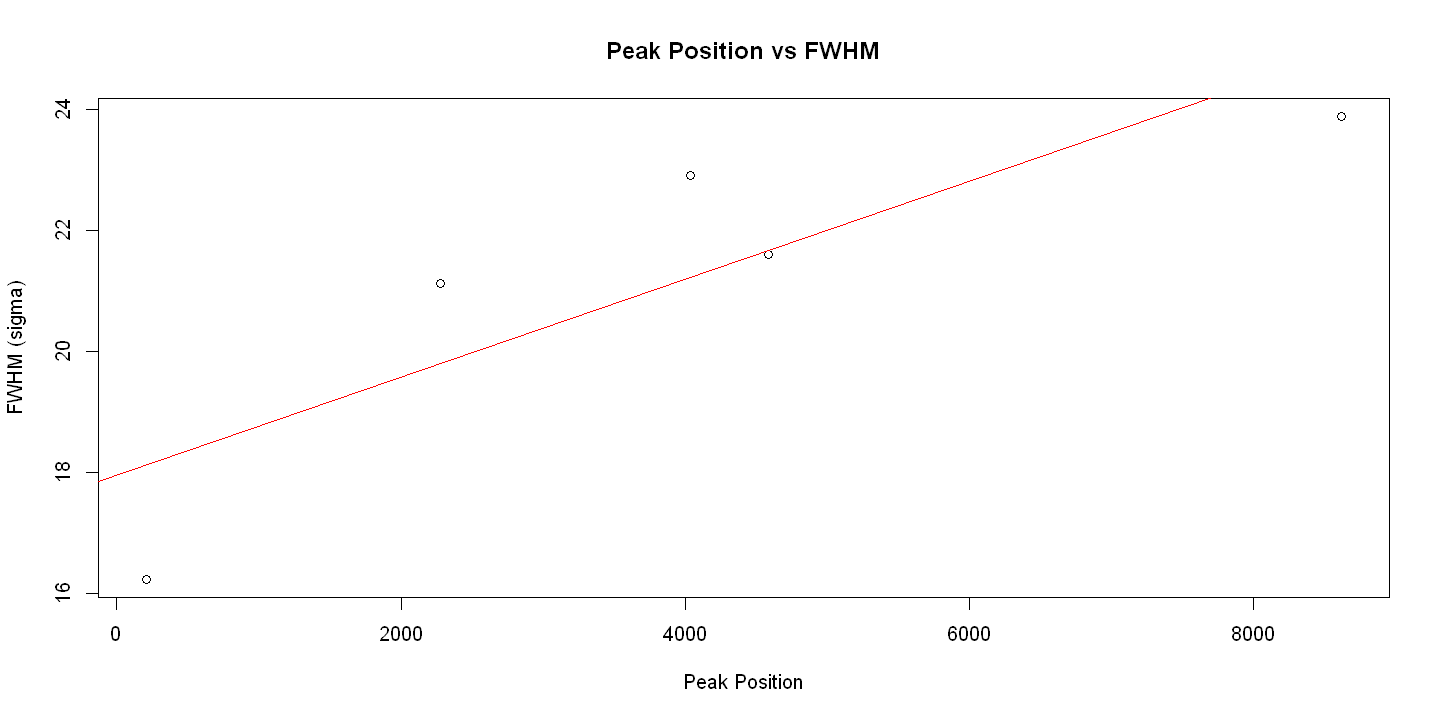

In [200]:
# Let's check the data
peak_positions <- peaks_AmCsCo
fwhm_values <- fwhm_values_AmCsCo

# Plotting peak positions against FWHM values
plot(peak_positions, fwhm_values,
     xlab = "Peak Position",
     ylab = "FWHM (sigma)",
     main = "Peak Position vs FWHM")

# Adding a linear regression line
abline(lm(fwhm_values ~ peak_positions), col = "red")

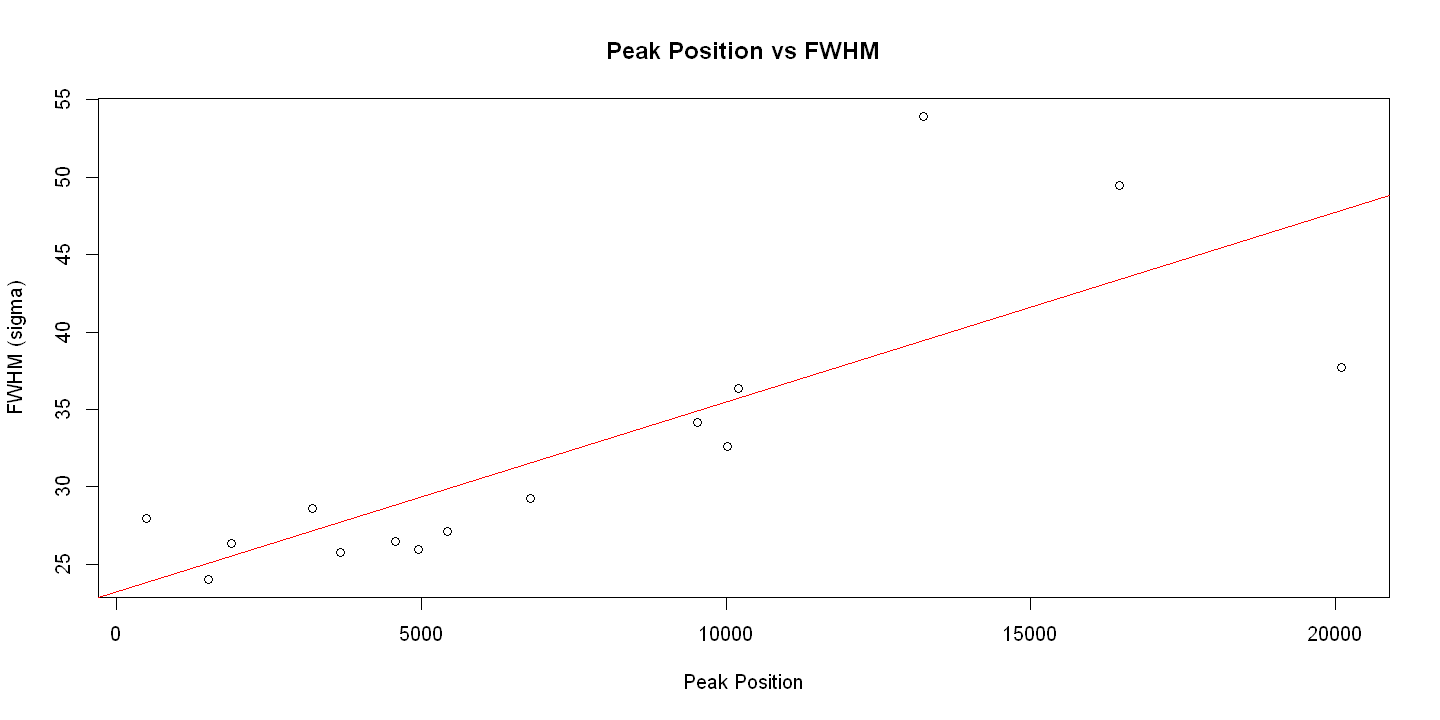

In [201]:
peak_positions <- peaks_Th
fwhm_values <- fwhm_values_Th

# Plotting peak positions against FWHM values
plot(peak_positions, fwhm_values,
     xlab = "Peak Position",
     ylab = "FWHM (sigma)",
     main = "Peak Position vs FWHM")

# Adding a linear regression line
abline(lm(fwhm_values ~ peak_positions), col = "red")

## Step 2: Calibration of Detector
To perform a calibration of the detector, we need to establish a relationship between the channel number (position of the peak) and the known energies of the gamma peaks. Assuming a linear response, this relationship can be expressed as:
$$ E=a⋅x+b $$

where:
* E is the energy in keV,
* x is the channel number,
* a and b are the calibration constants.
We can perform this calibration using a set of known gamma energies corresponding to the detected peaks.


 


In [202]:
# Functions 
# Function to convert channel to energy
channel_to_energy <- function(channel, model, predictor) {
  predict(model, newdata = setNames(data.frame(channel), predictor))
}

#### Steps to Perform Calibration
### 2.a Identify Known Gamma Energies: 
We need to have the nominal gamma peak energies for the isotopes in the data. 

In [203]:
# Given gamma energies (in keV) corresponding to the detected peaks
AmCsCo_energies <- c(59.5409, 661.657, 1173.228, 1332.492, 2505.69)
Th_energies <- c(238.632, 300.089, 510.74, 583.187, 727.330, 763.45 , 785.37, 860.53, 893.408, 1078.63, 1512.70, 1592.511, 1620.738, 2103.511, 2614.511)

# Create a data frame with the positions and corresponding energies
calibration_data_AmCsCo <- data.frame(
  Channel_AmCsCo = peaks_AmCsCo,
  Energy_AmCsCo = AmCsCo_energies
)
calibration_data_Th <- data.frame(
  Channel_Th = peaks_Th,
  Energy_Th = Th_energies
)

### 2.b Fit the Line: 
Use the identified peak positions (centroids) and their corresponding gamma energies to fit a linear model.


Call:
lm(formula = Energy_AmCsCo ~ Channel_AmCsCo, data = calibration_data_AmCsCo)

Residuals:
      1       2       3       4       5 
 0.5032 -0.1498 -0.3804 -0.3823  0.4093 

Coefficients:
                 Estimate Std. Error  t value Pr(>|t|)    
(Intercept)    -8.324e-01  3.829e-01   -2.174    0.118    
Channel_AmCsCo  2.906e-01  7.915e-05 3671.859 4.45e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4947 on 3 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.348e+07 on 1 and 3 DF,  p-value: 4.455e-11



Call:
lm(formula = Energy_Th ~ Channel_Th, data = calibration_data_Th)

Residuals:
     Min       1Q   Median       3Q      Max 
-240.233  -53.706    0.797   72.222  194.619 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.070e+02  4.970e+01   4.164  0.00111 ** 
Channel_Th  1.167e-01  5.347e-03  21.833 1.25e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 114.6 on 13 degrees of freedom
Multiple R-squared:  0.9735,	Adjusted R-squared:  0.9714 
F-statistic: 476.7 on 1 and 13 DF,  p-value: 1.253e-11


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


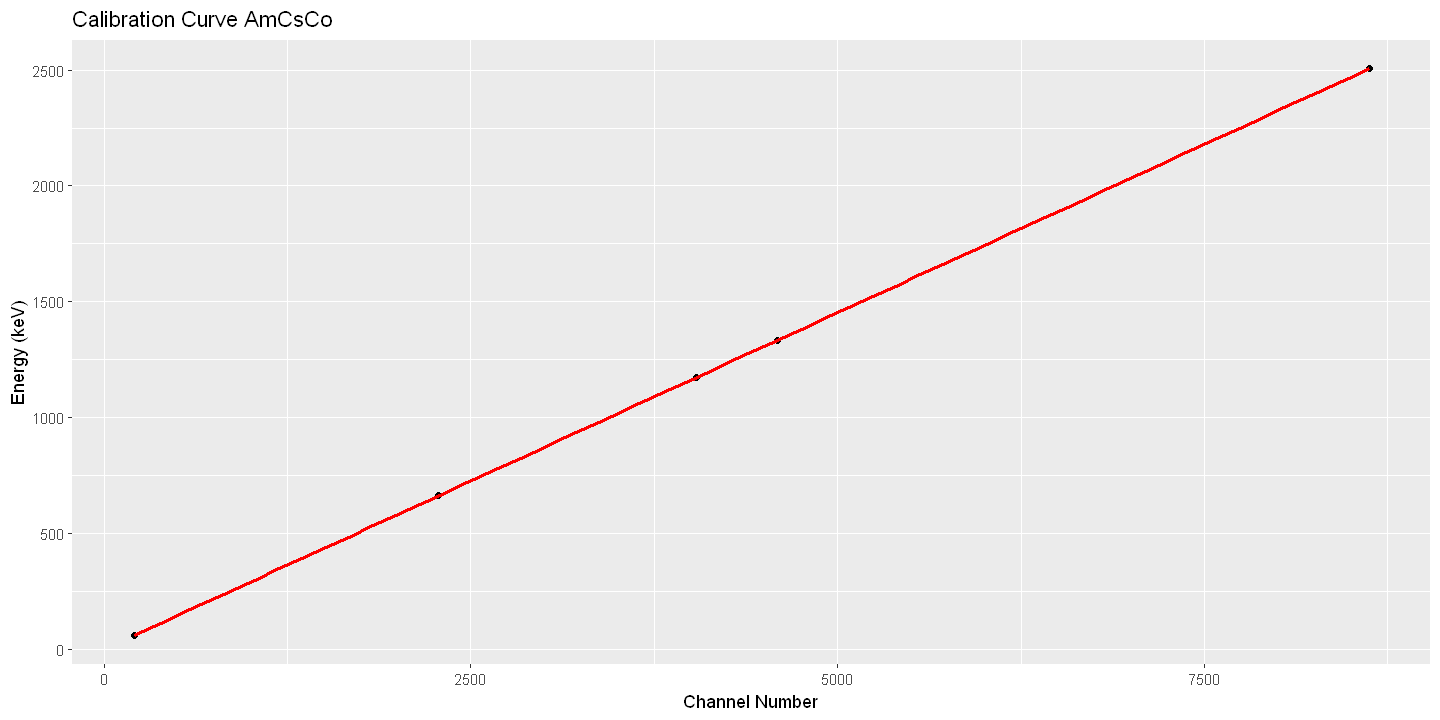

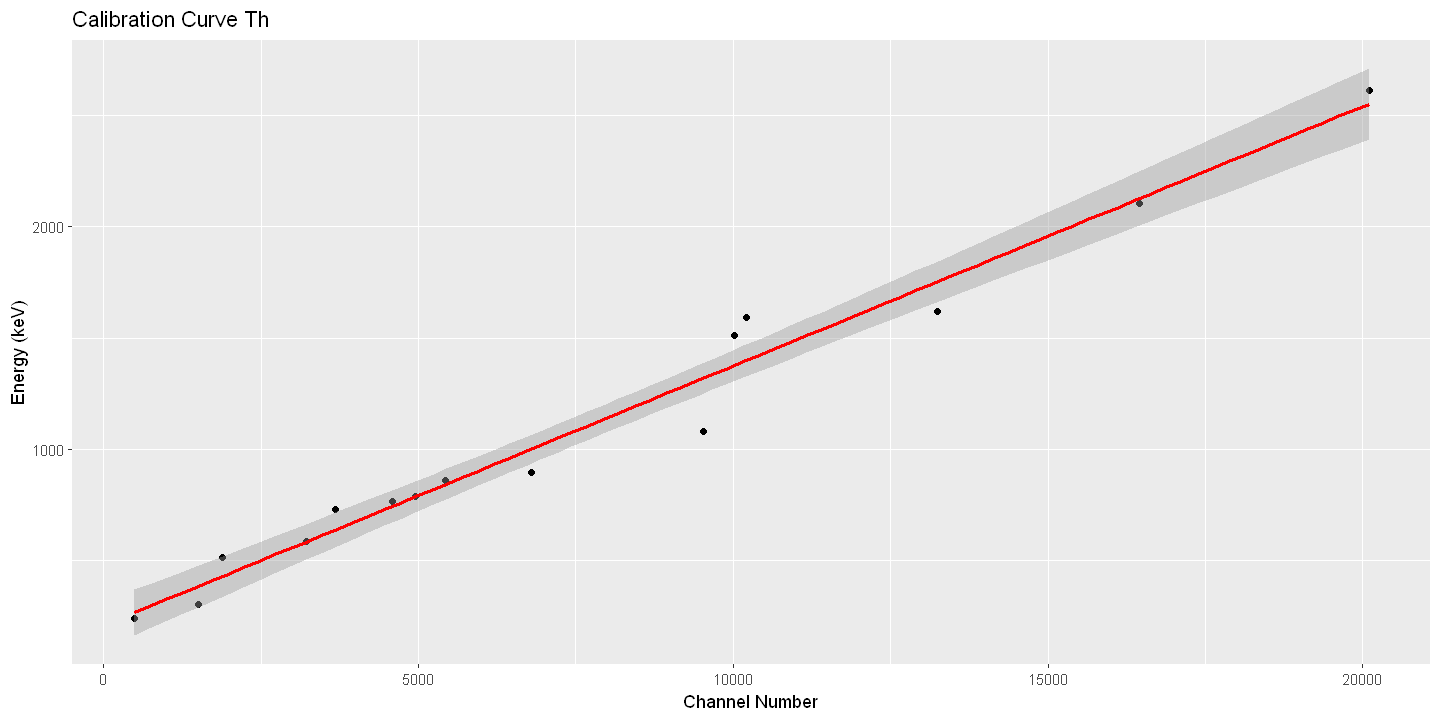

In [204]:
# Fit the linear model
calibration_model_AmCsCo <- lm(Energy_AmCsCo ~ Channel_AmCsCo, data = calibration_data_AmCsCo)
calibration_model_Th <- lm(Energy_Th ~ Channel_Th, data = calibration_data_Th)
summary(calibration_model_AmCsCo)
summary(calibration_model_Th)

# Plot the calibration data and the fitted model
ggplot(calibration_data_AmCsCo, aes(x = Channel_AmCsCo, y = Energy_AmCsCo)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve AmCsCo") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

ggplot(calibration_data_Th, aes(x = Channel_Th, y = Energy_Th)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve Th") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

### 2.c Apply Calibration: Use the linear model to convert channel numbers to energies.  

  Channel_AmCsCo Energy_AmCsCo
1            206      59.03767
2           2280     661.80683
3           4041    1173.60841
4           4589    1332.87432
5           8623    2505.28067

   Channel_Th Energy_Th
1         485  263.5911
2        1504  382.5427
3        1890  427.6019
4        3218  582.6242
5        3674  635.8547
6        4581  741.7322
7        4948  784.5734
8        5420  839.6717
9        6793  999.9471
10       9525 1318.8635
11      10025 1377.2303
12      10202 1397.8922
13      13240 1752.5291
14      16452 2127.4776
15      20099 2553.2053


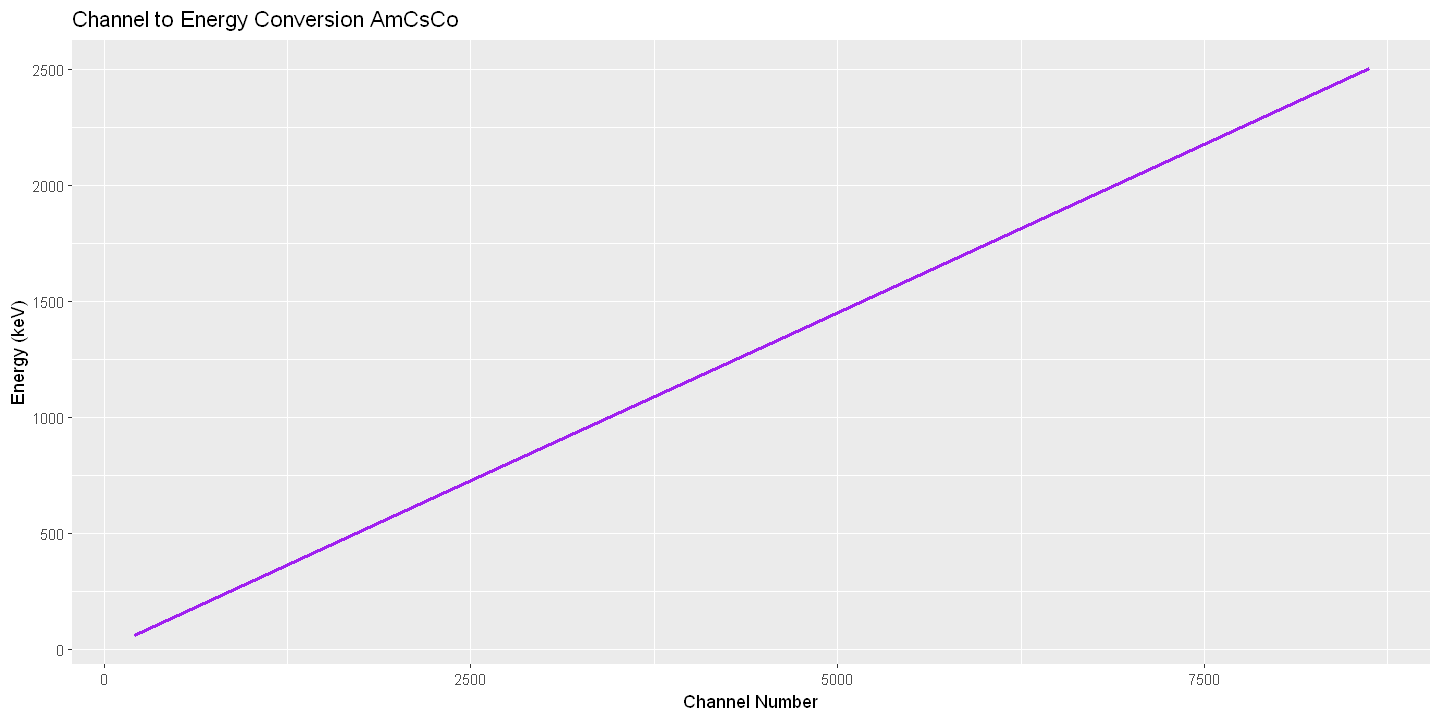

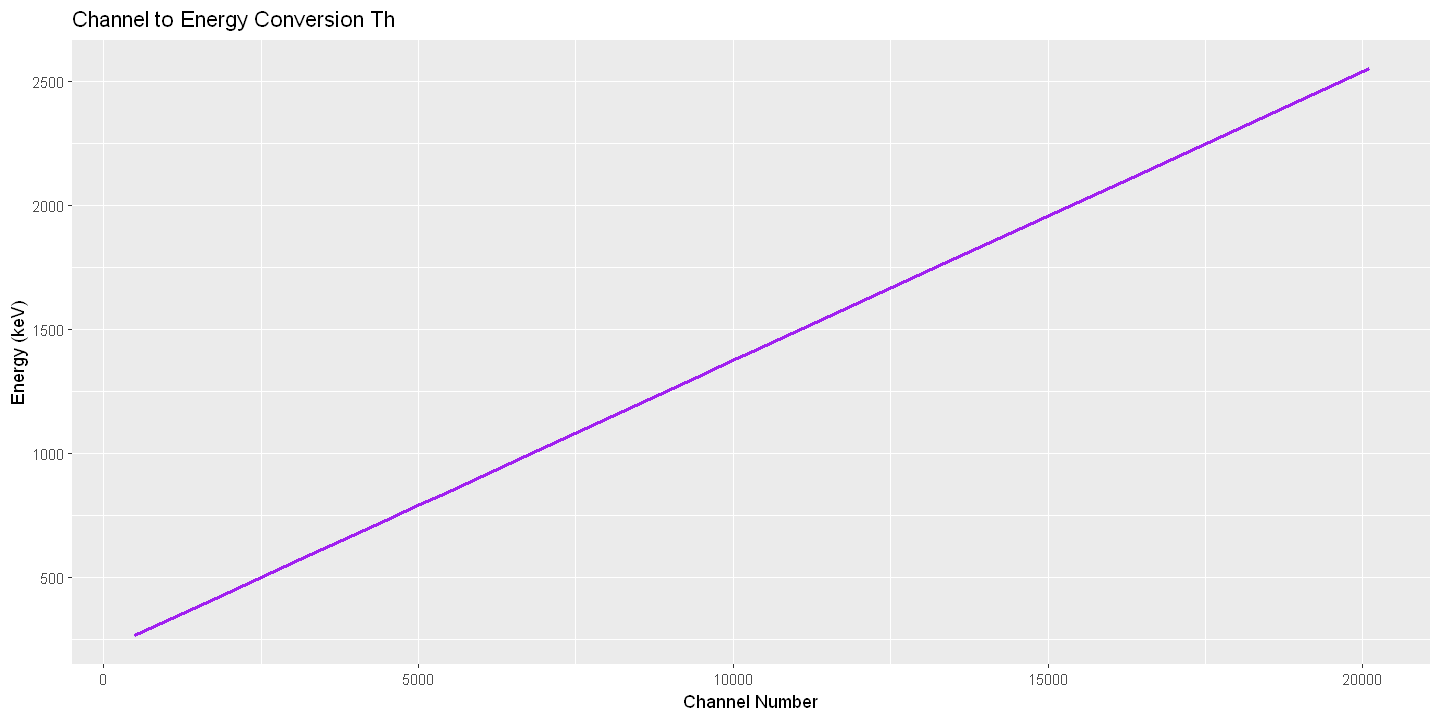

In [205]:
# Apply calibration to the channels
energies_AmCsCo <- channel_to_energy(calibration_data_AmCsCo$Channel_AmCsCo, calibration_model_AmCsCo, "Channel_AmCsCo")
energies_Th <- channel_to_energy(calibration_data_Th$Channel_Th, calibration_model_Th, "Channel_Th")

# Create a data frame with channels and corresponding energies
calibrated_data_AmCsCo <- data.frame(Channel_AmCsCo = calibration_data_AmCsCo$Channel_AmCsCo,
                              Energy_AmCsCo = energies_AmCsCo)
calibrated_data_Th <- data.frame(Channel_Th = calibration_data_Th$Channel_Th,
                              Energy_Th = energies_Th)

# Print the calibrated data
print(calibrated_data_AmCsCo)
cat('\n')
print(calibrated_data_Th)

# Plot the calibration results for AmCsCo
ggplot(calibrated_data_AmCsCo, aes(x = Channel_AmCsCo, y = Energy_AmCsCo)) +
  geom_line(col='purple', lwd=1.1) +
  ggtitle("Channel to Energy Conversion AmCsCo") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

# Plot the calibration results for Th
ggplot(calibrated_data_Th, aes(x = Channel_Th, y = Energy_Th)) +
  geom_line(col='purple', lwd=1.1) +
  ggtitle("Channel to Energy Conversion Th") +
  xlab("Channel Number") +
  ylab("Energy (keV)")



This chart shows the trend of the calculated energy for each channel number within the specified range, highlighting how the calibration transformed the channel numbers into gamma energies in keV.

**This suggests that there is a linear relationship between the detector channels and the gamma peak energies.**

Interpretation of Straight Lines in the Graphs:

Calibration Curve:
The "Calibration Curve" chart shows the calibration data (channels vs energies) and overlays a straight line representing the linear regression model fitted to the data.  
A straight line in this chart indicates that the calibration data can be well approximated by a linear model. This is often desirable as it simplifies the conversion of detector channels into gamma energies.

Channel Energy Conversion:
The "Channel Energy Conversion" chart shows the conversion of channels into energies for a range of channels.
A straight line in this chart indicates that the linear calibration model has been used to predict the energies for each channel within the specified range

## Step 3: Study Energy Resolution Using MCMC:
Using MCMC methods (with either JAGS or Stan), study the behavior of energy resolution as a function of photon energy.
Infer the parameters of the equations for FWHM and its components.

To study the behavior of the energy resolution as a function of the photon energy and infer the parameters using a Bayesian approach (with either JAGS or Stan), we need to model the Full Width at Half Maximum (FWHM) in terms of the provided equations.

##### Equations
$$ FWHM= \sqrt{(w_d^2+w_e^2)} $$
$$ w_d = 2  \sqrt{(2 \cdot \log(2)) \cdot F \cdot E_{\gamma} \cdot w}​ $$
 
Here, $E_\gamma$ is the photon energy, F is a parameter, and w is a parameter related to the detector.

##### Steps
* Model Definition: Define the Bayesian model using the equations.
* Data Preparation: Prepare the data for MCMC analysis.
* MCMC Simulation: Use Stan to run the MCMC simulation and infer the parameters.
* Result Analysis: Analyze the results to understand the behavior of energy resolution.



### 3.a Model Definition  
We need to translate the given equations into a form that can be used with MCMC methods. The parameters to be inferred are $w_e$,F, and w.  

In [269]:
# Define JAGS model code
jags_model_code <- "
model {
  for (i in 1:N) {
    w_d[i] <- 2 * sqrt(2 * log(2) * F * E_gamma[i] * w)
    FWHM[i] ~ dnorm(sqrt(w_d[i]^2 + w_e^2), prec)
  }
  
  F ~ dunif(0.02, 0.8)   # Prior uniforme per F
  w ~ dunif(2.3, 3.8)  # Prior uniforme per w
  w_e ~ dunif(1, 30)  # Prior uniforme per w_e
}
"


### 3.b Data Preparation    
We will use the energies and FWHM values from your data. Here are the values you provided earlier:

In [270]:
# Prepare data for JAGS
jags_data_AmCsCo <- list(
  N = length(energies_AmCsCo),
  E_gamma = energies_AmCsCo,
  FWHM = fwhm_values_AmCsCo,
  prec = 0.1  # Precisione per la distribuzione normale
)

jags_data_Th <- list(
  N = length(energies_Th),
  E_gamma = energies_Th,
  FWHM = fwhm_values_Th,
  prec = 0.1  # Precisione per la distribuzione normale
)

### 3.c MCMC Simulation  
Compile the Stan model and run the MCMC simulation:

In [271]:
# Compile and run the JAGS model
jags_model_AmCsCo <- jags.model(textConnection(jags_model_code), data = jags_data_AmCsCo, n.chains = 4)
update(jags_model_AmCsCo, 20000)  # Burn-in di 20k iterazioni
jags_samples_AmCsCo <- coda.samples(jags_model_AmCsCo, variable.names = c("F", "w", "w_e"), n.iter = 3000,, thin=2)

jags_model_Th <- jags.model(textConnection(jags_model_code), data = jags_data_Th, n.chains = 4)
update(jags_model_Th, 30000)  # Burn-in di 20k iterazioni
jags_samples_Th <- coda.samples(jags_model_Th, variable.names = c("F", "w", "w_e"), n.iter = 10000, thin=4)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 3
   Total graph size: 54

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 3
   Total graph size: 134

Initializing model




Iterations = 21002:24000
Thinning interval = 2 
Number of chains = 4 
Sample size per chain = 1500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
F    0.02223 0.002041 2.635e-05      4.236e-05
w    2.54895 0.231131 2.984e-03      4.614e-03
w_e 12.33664 2.441533 3.152e-02      4.134e-02

2. Quantiles for each variable:

       2.5%      25%      50%     75%   97.5%
F   0.02006  0.02067  0.02163  0.0232  0.0276
w   2.30721  2.37827  2.48143  2.6515  3.1723
w_e 7.14237 10.82322 12.47285 13.9935 16.7237


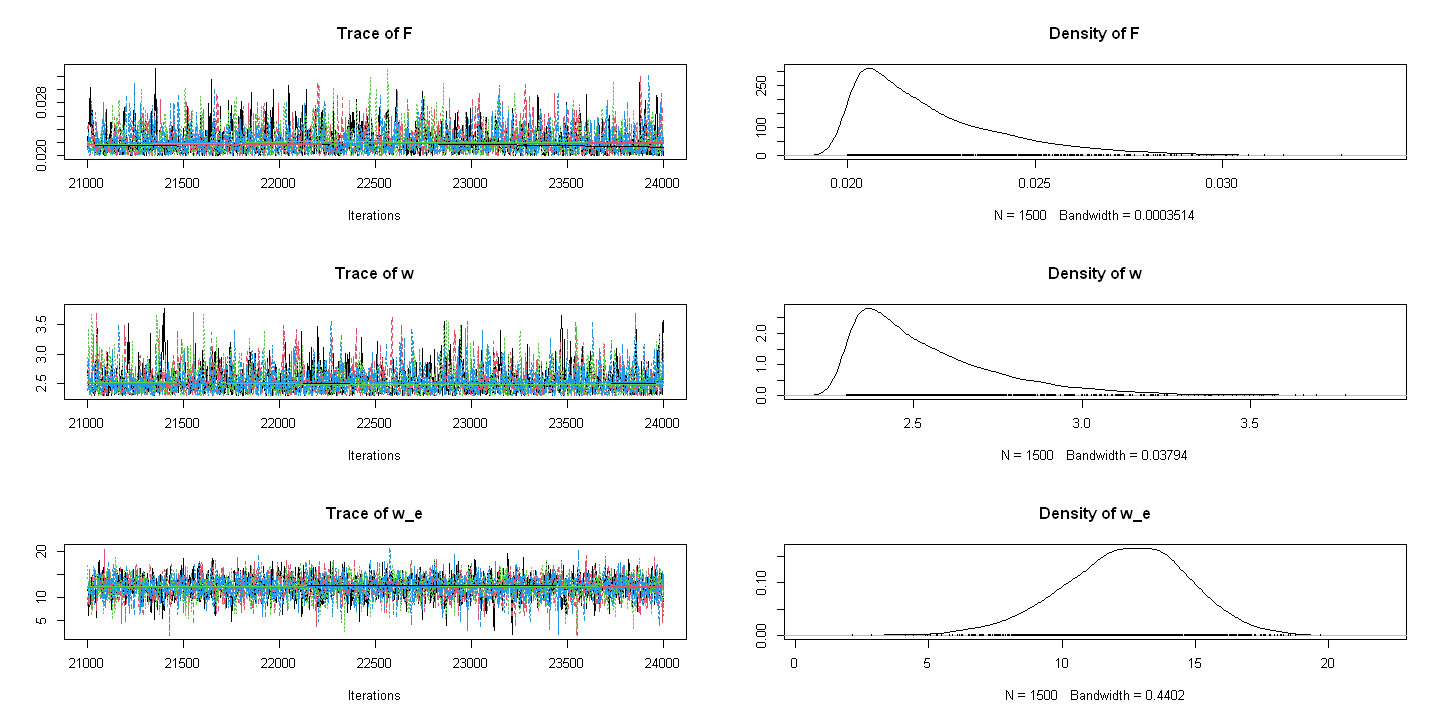

In [272]:
plot(jags_samples_AmCsCo)
summary(jags_samples_AmCsCo)


Iterations = 31004:41000
Thinning interval = 4 
Number of chains = 4 
Sample size per chain = 2500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
F    0.04461 0.008482 8.482e-05      0.0001913
w    2.97204 0.429473 4.295e-03      0.0091211
w_e 17.67577 2.652335 2.652e-02      0.0399371

2. Quantiles for each variable:

        2.5%      25%      50%      75%    97.5%
F    0.03004  0.03825  0.04405  0.05028  0.06223
w    2.32677  2.59711  2.93149  3.32496  3.74725
w_e 12.06206 16.03183 17.83556 19.50392 22.35423


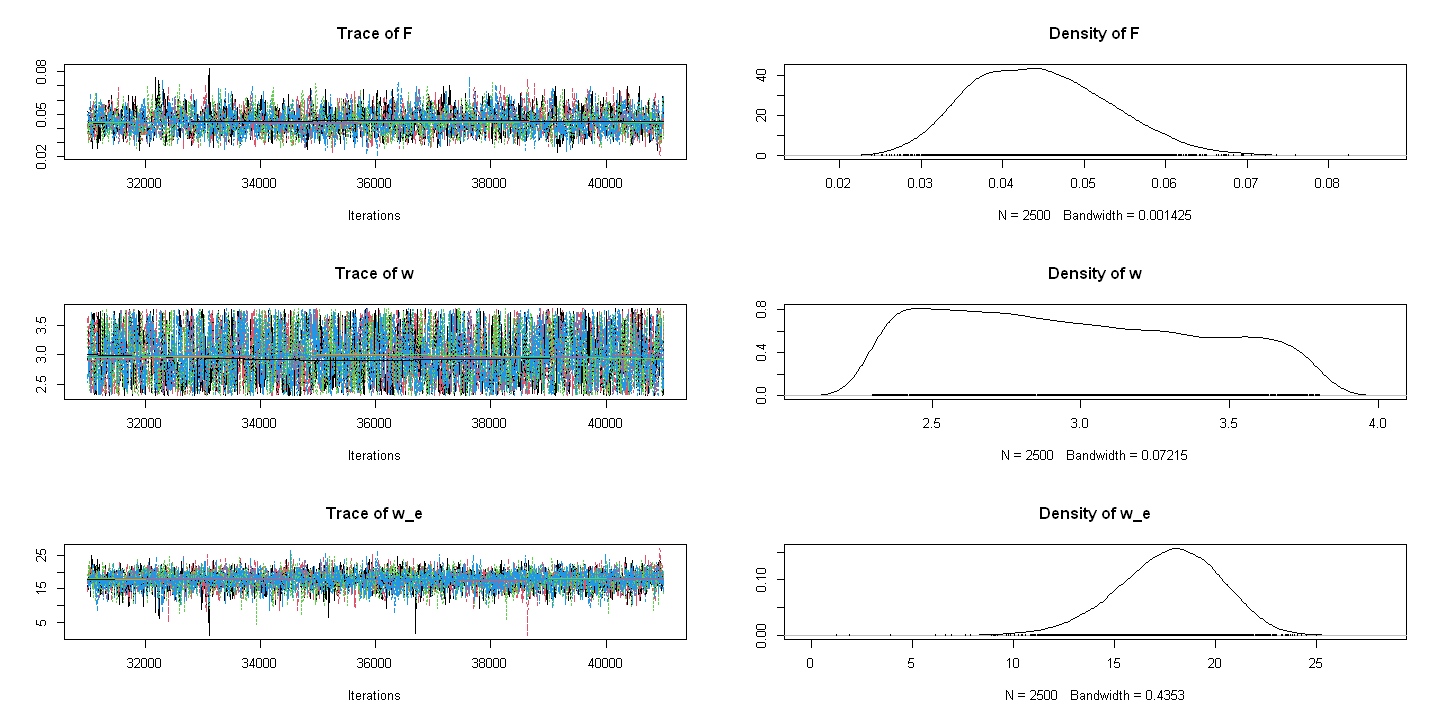

In [273]:
plot(jags_samples_Th)
summary(jags_samples_Th)

In [274]:
# Check the convergence of the chain
gelman.diag(jags_samples_AmCsCo)
gelman.diag(jags_samples_Th)


Potential scale reduction factors:

    Point est. Upper C.I.
F            1          1
w            1          1
w_e          1          1

Multivariate psrf

1

Potential scale reduction factors:

    Point est. Upper C.I.
F            1          1
w            1          1
w_e          1          1

Multivariate psrf

1

The Gelman-Rubin diagnostics (Potential Scale Reduction Factor, PSRF) indicate that the chains have likely converged. Specifically:

A Point Estimate of 1 for all parameters indicates good convergence.  
An Upper C.I. (Upper Confidence Interval) close to 1 (1.01) is another sign of good convergence.

In [275]:
# Check the autocorrelation
autocorr.diag(jags_samples_AmCsCo)
autocorr.diag(jags_samples_Th)

,F,w,w_e
Lag 0,1.000000000,1.000000e+00,1.0000000000
Lag 2,0.407572207,4.080976e-01,0.2095489381
Lag 10,0.035449301,2.449369e-02,-0.0009386147
Lag 20,0.012864462,4.553882e-02,-0.0073445970
Lag 100,-0.009673661,2.825392e-05,-0.0073553717


,F,w,w_e
Lag 0,1.000000000,1.000000000,1.00000000
Lag 4,0.669490624,0.615917802,0.37495363
Lag 20,0.139075928,0.115261107,0.03207898
Lag 40,0.005449185,-0.006602298,0.01188584
Lag 200,-0.010782070,-0.022379619,-0.01567256


**Lag 0**: Autocorrelation is always 1 at lag 0, representing the correlation of the sample with itself.  
**Low Lags (Lag 2, 4, 10)**: These values show the correlation between samples that are close to each other. For `jags_samples_AmCsCo`, autocorrelation at lag 2 is around 0.31 for `F` and 0.41 for `w_e`, indicating moderate correlation. For `jags_samples_Th`, the autocorrelation at lag 4 is higher, especially for `F` (0.72) and `w` (0.74), indicating strong correlation.  
**Medium to High Lags (Lag 20, 40, 100, 200)**: As the lag increases, the autocorrelation decreases, approaching zero, which is desirable. This indicates that the samples become less correlated and more independent as the lag increases.

### 3.d Result Analysis  
Extract the results and analyze the parameters:

Estimated parameters (JAGS):
F: 0.02222968 
w: 2.54895 
w_e: 12.33664 


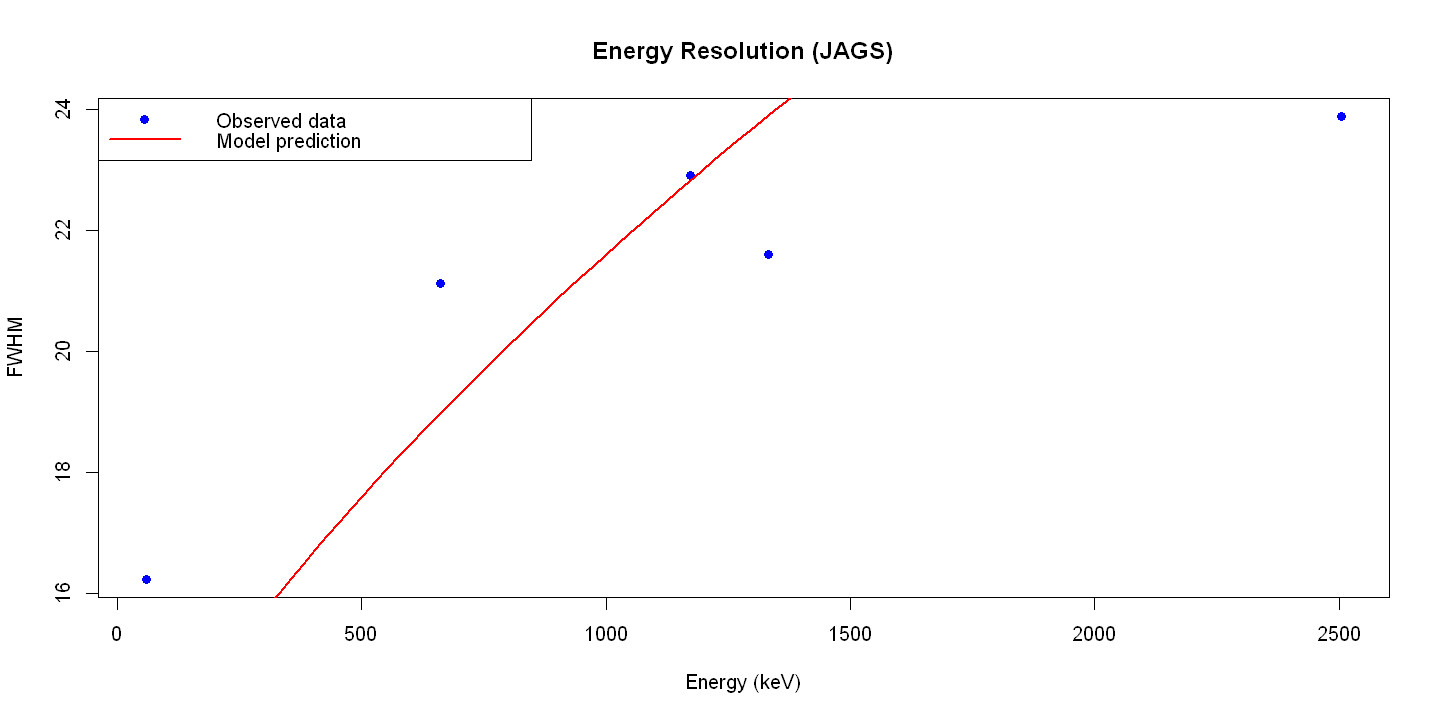

In [276]:
# Extract results from JAGS
results_jags <- as.matrix(jags_samples_AmCsCo)

# Get posterior estimates for parameters
F_est_jags <- mean(results_jags[, "F"])
w_est_jags <- mean(results_jags[, "w"])
w_e_est_jags <- mean(results_jags[, "w_e"])

# Print estimated parameters
cat("Estimated parameters (JAGS):\n")
cat("F:", F_est_jags, "\n")
cat("w:", w_est_jags, "\n")
cat("w_e:", w_e_est_jags, "\n")

# Plot the energy resolution function
energy_range_jags <- seq(min(energies_AmCsCo), max(energies_AmCsCo), length.out = 100)
w_d_jags <- 2 * sqrt(2 * log(2) * F_est_jags * energy_range_jags * w_est_jags)
predicted_fwhm_jags <- sqrt(w_d_jags^2 + w_e_est_jags^2)
plot(energies_AmCsCo, fwhm_values_AmCsCo, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution (JAGS)")
lines(energy_range_jags, predicted_fwhm_jags, col = "red", lwd = 2)
legend("topleft", legend = c("Observed data", "Model prediction"),
       col = c("blue", "red"), pch = c(19, NA), lty = c(NA, 1), lwd = c(NA, 2))

Estimated parameters (JAGS):
F: 0.04460901 
w: 2.972042 
w_e: 17.67577 


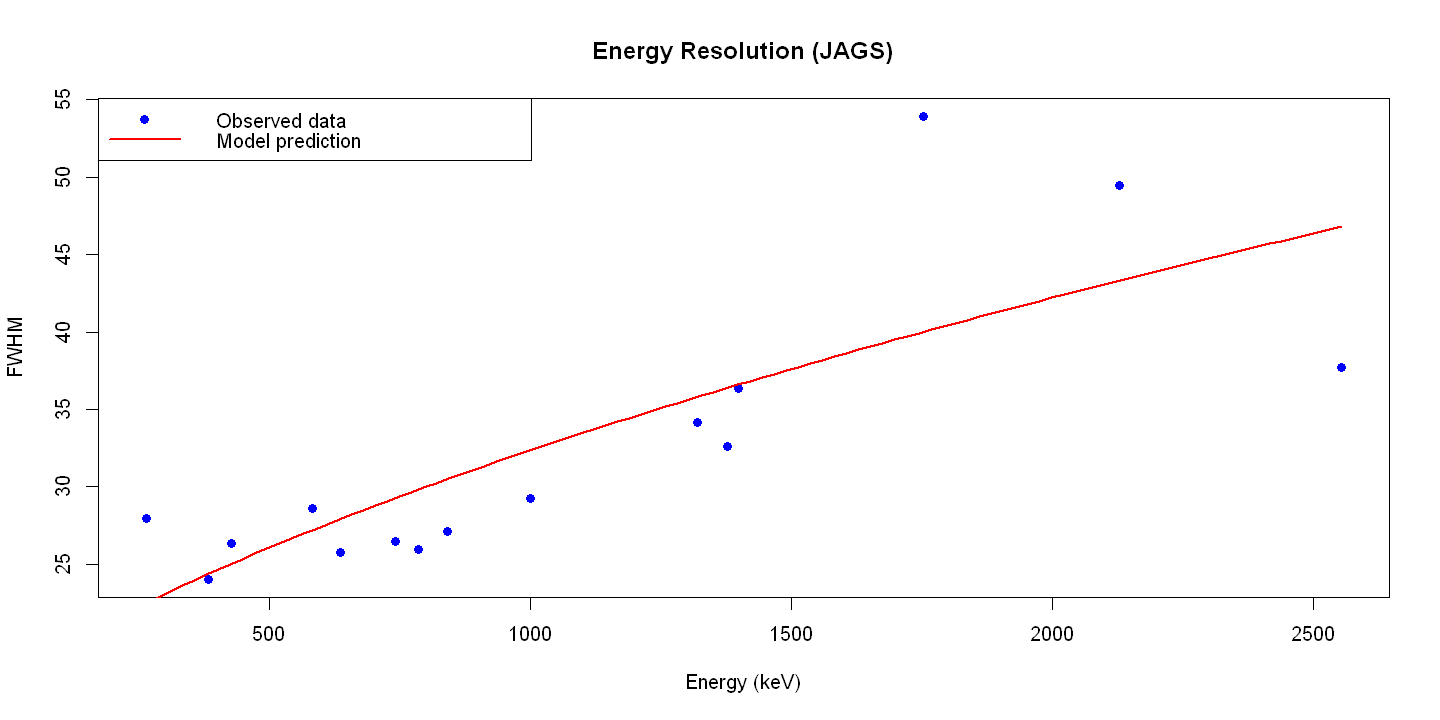

In [277]:
# Extract results from JAGS
results_jags <- as.matrix(jags_samples_Th)

# Get posterior estimates for parameters
F_est_jags <- mean(results_jags[, "F"])
w_est_jags <- mean(results_jags[, "w"])
w_e_est_jags <- mean(results_jags[, "w_e"])

# Print estimated parameters
cat("Estimated parameters (JAGS):\n")
cat("F:", F_est_jags, "\n")
cat("w:", w_est_jags, "\n")
cat("w_e:", w_e_est_jags, "\n")

# Plot the energy resolution function
energy_range_jags <- seq(min(energies_Th), max(energies_Th), length.out = 100)
w_d_jags <- 2 * sqrt(2 * log(2) * F_est_jags * energy_range_jags * w_est_jags)
predicted_fwhm_jags <- sqrt(w_d_jags^2 + w_e_est_jags^2)
plot(energies_Th, fwhm_values_Th, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution (JAGS)")
lines(energy_range_jags, predicted_fwhm_jags, col = "red", lwd = 2)
legend("topleft", legend = c("Observed data", "Model prediction"),
       col = c("blue", "red"), pch = c(19, NA), lty = c(NA, 1), lwd = c(NA, 2))

In this graph, the observed data (blue dots) and the predicted model (red line) for energy resolution are represented.  
On the x-axis, the energy in keV of the detected gamma peaks is indicated, while the y-axis shows the FWHM of these peaks.

The blue points show the experimental measurements of the energy resolution (FWHM) at various energies. The red line shows the energy resolution predicted by the JAGS model based on the parameters estimated from the data.  
This line closely follows the distribution of the blue points (more so for Th than for AmCsCo), indicating that the predicted model is in good agreement with the observed data, suggesting that the estimated parameters ($F$, $w$, $w_e$) are a good representation of the detector's characteristics.  
As for the AmCsCo graph, the red line follows the distribution of the blue points but not perfectly. This could indicate that the model is not capturing all aspects of the detector's energy resolution or that the observed data used in the model is too sparse to achieve an optimal result.

## Step 4: Energy resolution for NaI detector

### 4.a Data inspectionad FWHM derivation

In [278]:
# Extract data points around each peak
peak_data_list_co60  <- extract_peak_data(gr11_co60, peaks_co60, window_size = 110)
peak_data_list_cs137  <- extract_peak_data(gr11_cs137, peaks_cs137, window_size = 100)
peak_data_list_na22  <- extract_peak_data(gr11_na22, peaks_na22, window_size = 100)
print(peak_data_list_co60) 

$`3057`
     Channel Count log_Count
1419    2837   398  5.988961
1420    2839   408  6.013715
1421    2841   392  5.973810
1422    2843   400  5.993961
1423    2845   343  5.840642
1424    2847   388  5.963579
1425    2849   392  5.973810
1426    2851   393  5.976351
1427    2853   427  6.059123
1428    2855   357  5.880533
1429    2857   404  6.003887
1430    2859   374  5.926926
1431    2861   363  5.897154
1432    2863   422  6.047372
1433    2865   427  6.059123
1434    2867   377  5.934894
1435    2869   393  5.976351
1436    2871   413  6.025866
1437    2873   433  6.073045
1438    2875   363  5.897154
1439    2877   467  6.148468
1440    2879   407  6.011267
1441    2881   475  6.165418
1442    2883   392  5.973810
1443    2885   422  6.047372
1444    2887   488  6.192362
1445    2889   484  6.184149
1446    2891   430  6.066108
1447    2893   460  6.133398
1448    2895   478  6.171701
1449    2897   534  6.282267
1450    2899   505  6.226537
1451    2901   485  6.186209
1452  

In [279]:
# Fit the model for each peak
fits_co60 <- lapply(peak_data_list_co60, fit_gaussian_nls)
fits_cs137 <- lapply(peak_data_list_cs137, fit_gaussian_nls)
fits_na22 <- lapply(peak_data_list_na22, fit_gaussian_nls)

# Calculate FWHM for each peak
fwhm_values_co60 <- sapply(fits_co60, calculate_fwhm)
fwhm_values_cs137 <- sapply(fits_cs137, calculate_fwhm)
fwhm_values_na22 <- sapply(fits_na22, calculate_fwhm)

fwhm_values_NaI <- c(fwhm_values_cs137, fwhm_values_co60, fwhm_values_na22)


# Extract the names (keys)
channels <- names(fwhm_values_NaI)

# Remove ".sigma" from the names to sort correctly
channels_numeric <- as.numeric(gsub(".sigma", "", channels))

# Sort the keys and get the sorting index
order_indices <- order(channels_numeric)

# Sort the keys
sorted_channels <- channels[order_indices]

# Reorder the FWHM values according to the order of the keys
fwhm_values_NaI <- fwhm_values_NaI[order_indices]

# Assign the sorted names to the sorted values
names(fwhm_values_NaI) <- sorted_channels

# Print the FWHM values sorted by channel
print(fwhm_values_NaI)


1365.sigma 1779.sigma 3057.sigma 3301.sigma 3457.sigma 
  455.0826   408.0380   566.9261   433.2674   498.4216 


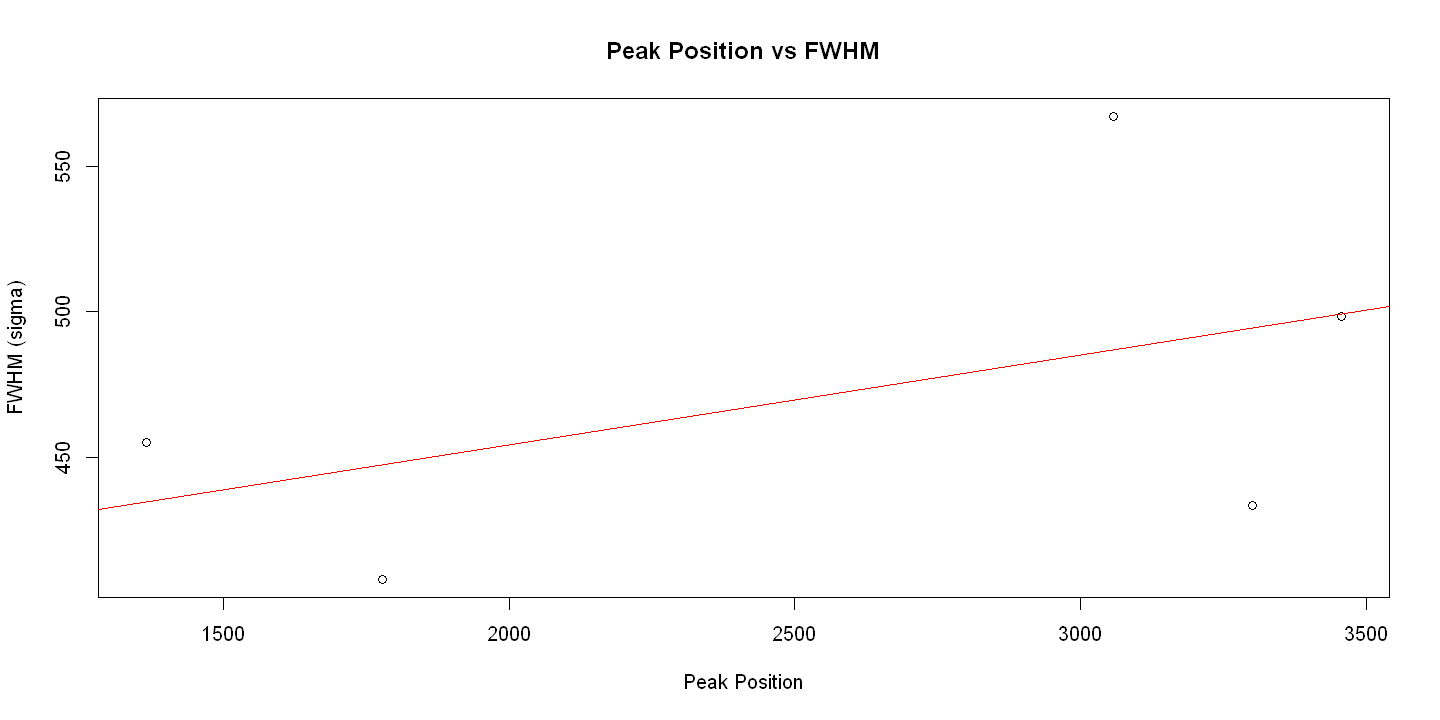

In [280]:
peaks <- c(peaks_cs137, peaks_co60, peaks_na22)

peaks_NaI <- sort(peaks)

# Plotting peak positions against FWHM values
plot(peaks_NaI, fwhm_values_NaI,
     xlab = "Peak Position",
     ylab = "FWHM (sigma)",
     main = "Peak Position vs FWHM")

# Adding a linear regression line
abline(lm(fwhm_values_NaI ~ peaks_NaI), col = "red")


### 4.b Calibration of the detector


Call:
lm(formula = Energy_NaI ~ Channel_NaI, data = calibration_data_NaI)

Residuals:
      1       2       3       4       5 
 5.8764 -7.2913 -1.4399  3.3154 -0.4606 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -35.023030   8.303816  -4.218   0.0244 *  
Channel_NaI   0.395712   0.003043 130.020    1e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.802 on 3 degrees of freedom
Multiple R-squared:  0.9998,	Adjusted R-squared:  0.9998 
F-statistic: 1.691e+04 on 1 and 3 DF,  p-value: 1.003e-06


`geom_smooth()` using formula = 'y ~ x'


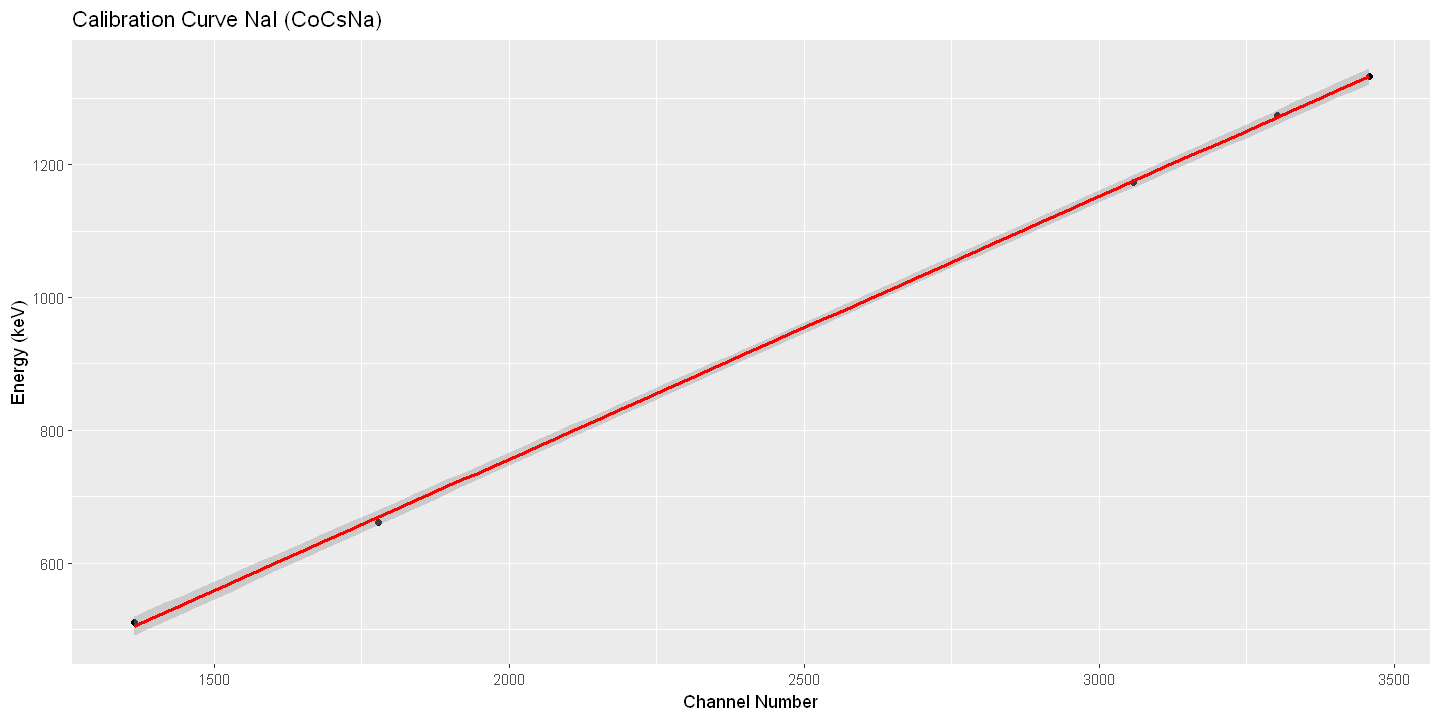

In [281]:
# Identify Known gamma energies
NaI_energies <- c(1173.228, 1332.492, 661.657, 511, 1274.537)
NaI_energies <- sort(NaI_energies)
#cat('Nai energies: \n', NaI_energies)

# Create a data frame with the positions and corresponding energies
calibration_data_NaI <- data.frame(
    Channel_NaI = peaks_NaI,
    Energy_NaI = NaI_energies
)

# Fit the linear model 
calibration_model_NaI <- lm(Energy_NaI ~ Channel_NaI, data= calibration_data_NaI)
summary(calibration_model_NaI)

# Plot the calibration data and the fitted model
ggplot(calibration_data_NaI, aes(x = Channel_NaI, y = Energy_NaI)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve NaI (CoCsNa)") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

  Channel_NaI Energy_NaI
1        1365   505.1236
2        1779   668.9483
3        3057  1174.6679
4        3301  1271.2216
5        3457  1332.9526


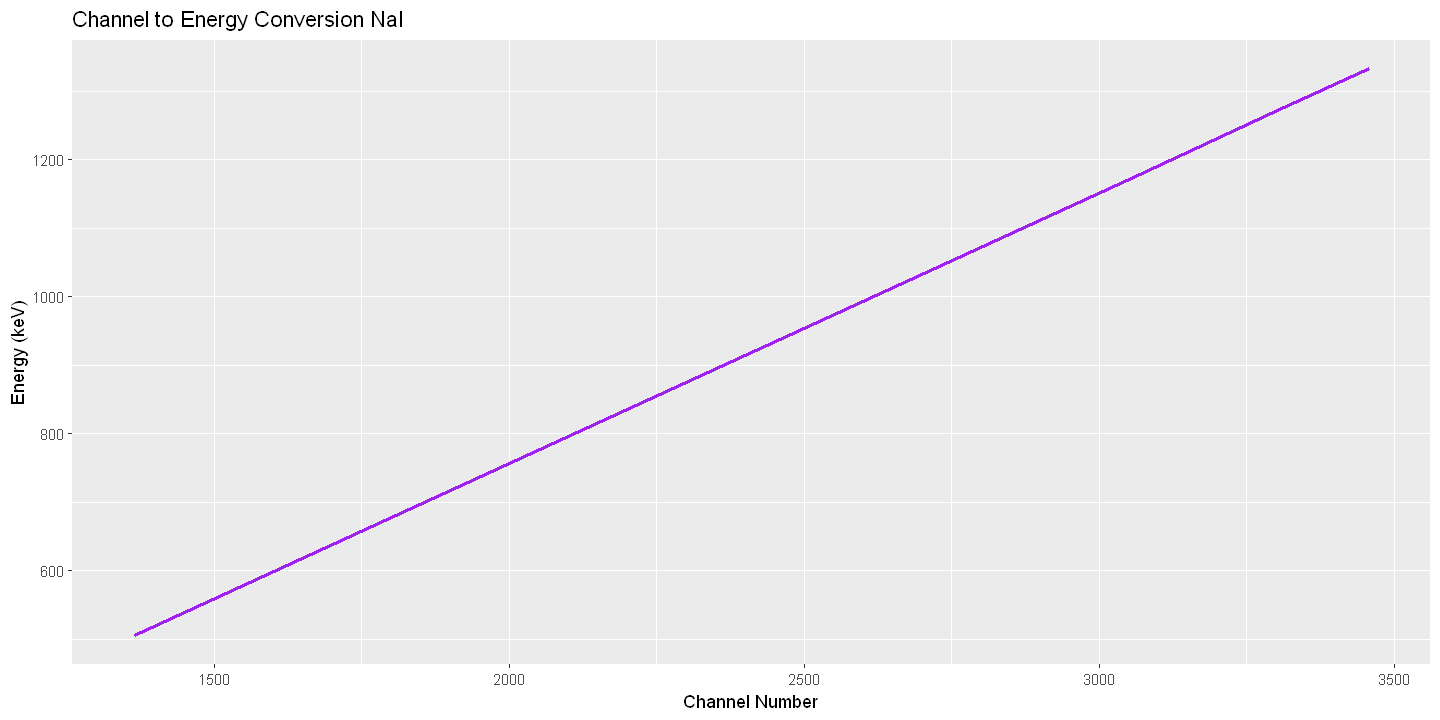

In [282]:
# Apply calibration to the channels
energies_NaI <- channel_to_energy(calibration_data_NaI$Channel_NaI, calibration_model_NaI, "Channel_NaI")

# Create data frames with channels and corresponding energies
calibrated_data_NaI<- data.frame(
    Channel_NaI = calibration_data_NaI$Channel_NaI,
    Energy_NaI = energies_NaI)

print(calibrated_data_NaI )

# Plot the calibration results for AmCsCo
ggplot(calibrated_data_NaI, aes(x = Channel_NaI, y = Energy_NaI)) +
  geom_line(col='purple', lwd=1.1) +
  ggtitle("Channel to Energy Conversion NaI") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

### 4.c Study energy resolution using MCMC

In [283]:
# Define JAGS model code
# F ~ 0.1
jags_model_code_NaI <- "
# w ~ 5.9 eV
model {
  for (i in 1:N) {
    w_d[i] <- 2 * sqrt(2 * log(2) * F * E_gamma[i] * w)
    FWHM[i] ~ dnorm(sqrt(w_d[i]^2 + w_e^2), prec)
  }
  
  F ~ dunif(0, 0.5)   # Prior uniforme per F
  w ~ dunif(4.5, 7)  # Prior uniforme per w
  w_e ~ dunif(400, 500)  # Prior uniforme per w_e
}
"

In [284]:
# Prepare data for JAGS
jags_data_NaI <- list(
  N = length(energies_NaI),
  E_gamma = energies_NaI,
  FWHM = fwhm_values_NaI,
  prec = 0.1  # Precisione per la distribuzione normale
)

In [285]:
# Compile and run the JAGS models
jags_model_NaI <- jags.model(textConnection(jags_model_code_NaI), data = jags_data_NaI, n.chains = 4)
update(jags_model_NaI, 20000)  # Burn-in di 20k iterazioni
jags_samples_NaI <- coda.samples(jags_model_NaI, variable.names = c("F", "w", "w_e"), n.iter = 3000, thin = 2)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 3
   Total graph size: 54

Initializing model




Iterations = 21002:24000
Thinning interval = 2 
Number of chains = 4 
Sample size per chain = 1500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
F     0.4928 0.007241 9.349e-05      0.0001544
w     6.8950 0.105160 1.358e-03      0.0023088
w_e 451.9126 1.562414 2.017e-02      0.0229839

2. Quantiles for each variable:

        2.5%      25%     50%      75%    97.5%
F     0.4731   0.4899   0.495   0.4979   0.4998
w     6.6240   6.8549   6.926   6.9694   6.9973
w_e 448.8187 450.8432 451.914 452.9446 455.0100


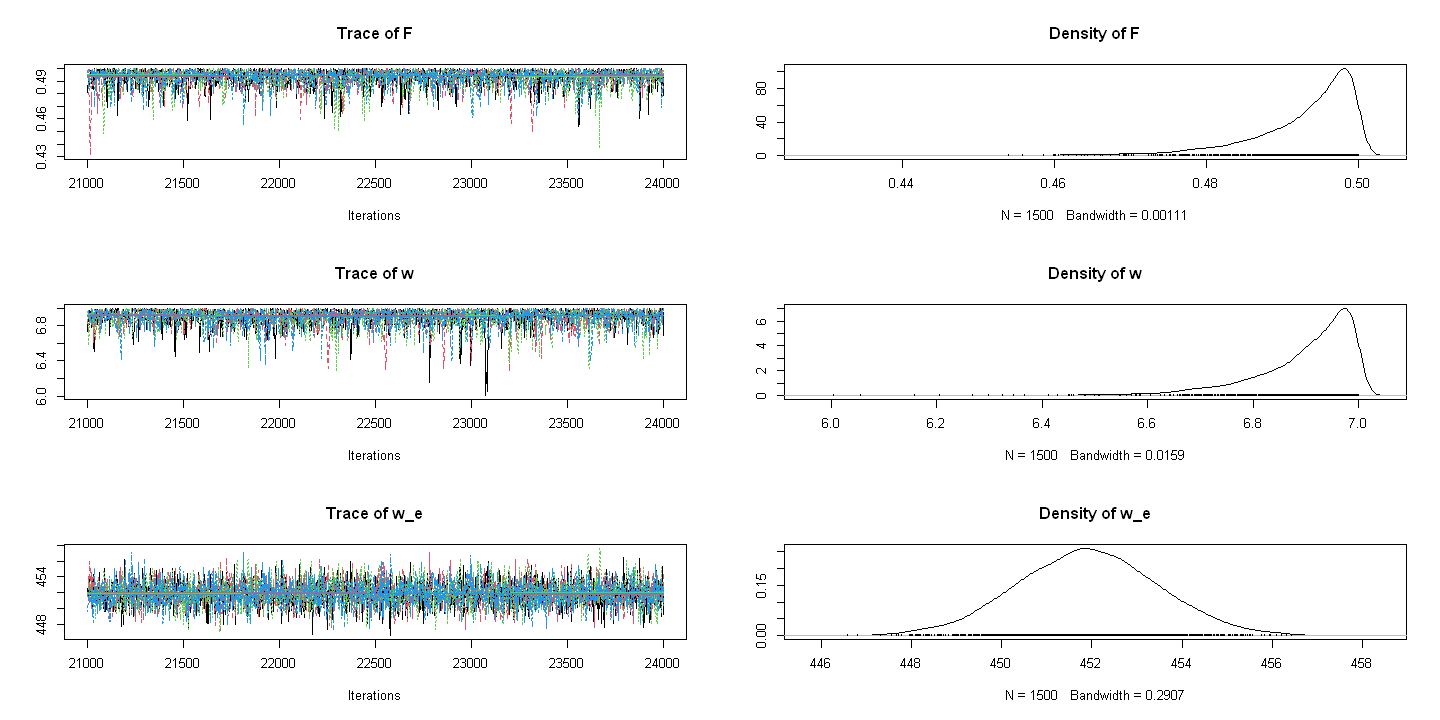

In [286]:
plot(jags_samples_NaI)
summary(jags_samples_NaI)

In [287]:
# Check the convergence of the chain
gelman.diag(jags_samples_NaI)

Potential scale reduction factors:

    Point est. Upper C.I.
F            1          1
w            1          1
w_e          1          1

Multivariate psrf

1

In [288]:
# Check the autocorrelation
autocorr.diag(jags_samples_NaI)

,F,w,w_e
Lag 0,1.000000000,1.00000000,1.000000000
Lag 2,0.468723931,0.47211188,0.103131735
Lag 10,0.009280228,0.01371265,-0.010186694
Lag 20,0.012644806,-0.01013612,0.007780802
Lag 100,0.010236447,0.01503405,-0.017749657


### 4.d Result Analysis

Estimated parameters (JAGS):
F: 0.4927595 
w: 6.894969 
w_e: 451.9126 


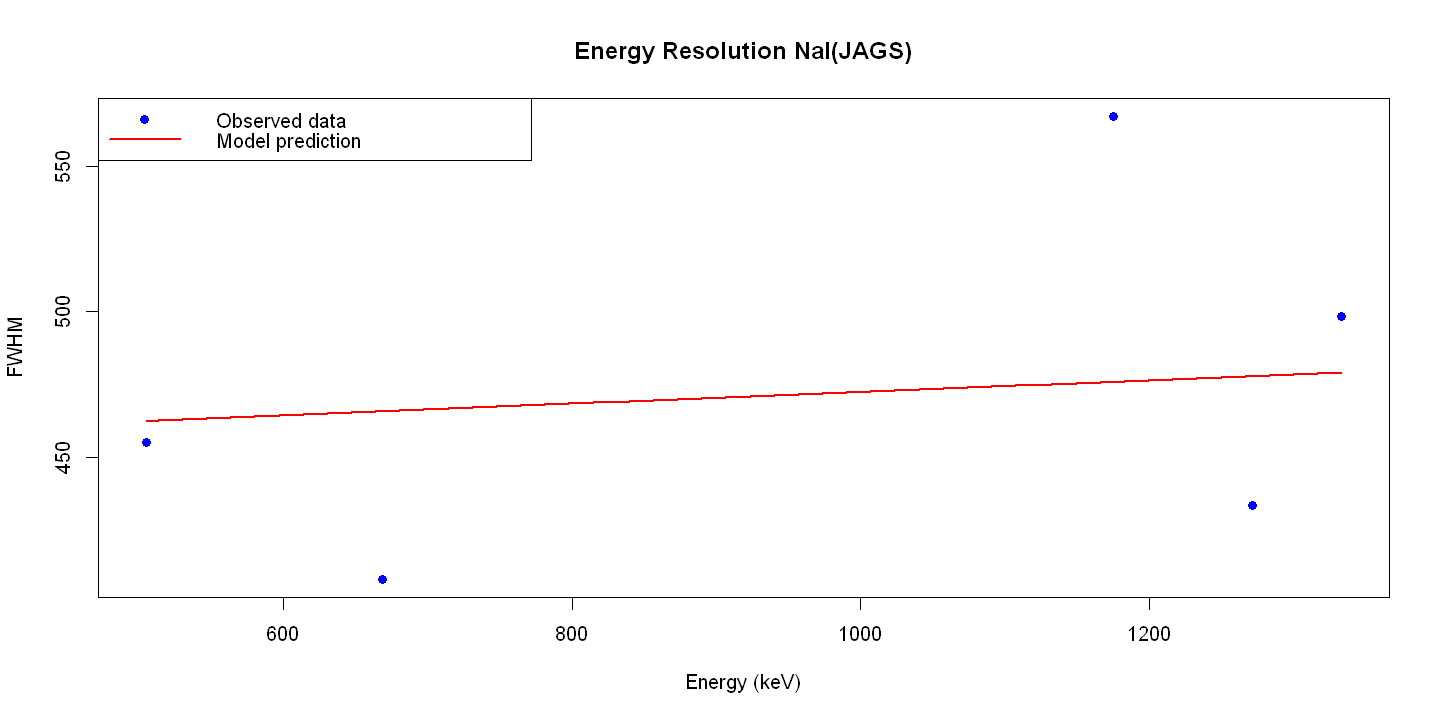

In [289]:
# Extract results from JAGS
results_jags <- as.matrix(jags_samples_NaI)

# Get posterior estimates for parameters
F_est_jags <- mean(results_jags[, "F"])
w_est_jags <- mean(results_jags[, "w"])
w_e_est_jags <- mean(results_jags[, "w_e"])

# Print estimated parameters
cat("Estimated parameters (JAGS):\n")
cat("F:", F_est_jags, "\n")
cat("w:", w_est_jags, "\n")
cat("w_e:", w_e_est_jags, "\n")

# Plot the energy resolution function
energy_range_jags <- seq(min(energies_NaI), max(energies_NaI), length.out = 100)
w_d_jags <- 2 * sqrt(2 * log(2) * F_est_jags * energy_range_jags * w_est_jags)
predicted_fwhm_jags <- sqrt(w_d_jags^2 + w_e_est_jags^2)
plot(energies_NaI, fwhm_values_NaI, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution NaI(JAGS)")
lines(energy_range_jags, predicted_fwhm_jags, col = "red", lwd = 2)
legend("topleft", legend = c("Observed data", "Model prediction"),
       col = c("blue", "red"), pch = c(19, NA), lty = c(NA, 1), lwd = c(NA, 2))